# GAN setup and training

### This notebook is based on [this blogpost](https://www.toptal.com/machine-learning/generative-adversarial-networks) and its [github repo](https://github.com/codyznash/GANs_for_Credit_Card_Data).


Resources:

https://github.com/wayaai/GAN-Sandbox
<br>
http://blog.richardweiss.org/2017/07/21/conditional-wasserstein-gan.html

Conversion of Waya.ai GAN and WGAN
- Remove convolutional layers
- Remove ResNeXt
- Add simple dense networks
- Convert WGAN back to simple GAN
- Use common functions as much as possible

For these functions I've passed the arguments as lists because it was easy to implement.

Standard solutions (because they are more stable) include using keyword dictionaries or objects, but those create a larger code base.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import os
import sklearn.cluster as cluster

from utils_GAN import *

Using TensorFlow backend.


In [3]:
# Load engineered dataset from EDA section
data = pickle.load(open('./credicard.engineered.pkl','rb'))

In [4]:
# Set up training set to consist of only fraud data
train = data.loc[ data['Class']==1 ].copy()

print( pd.DataFrame( [ [np.sum(train['Class']==i)] for i in np.unique(train['Class']) ], columns=['count'], index=np.unique(train['Class']) ) )

# train = pd.get_dummies(train, columns=['Class'], prefix='Class')
label_cols = [ i for i in train.columns if 'Class' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]
train_no_label = train[ data_cols ]

   count
1    492


In [5]:
print(train.shape)
train.head()

(492, 31)


Time        V1        V2        V3        V4        V5        V6  \
541  -2.476422 -1.285321  1.356311 -1.142574  2.892001 -0.434176 -1.128384   
623  -2.473276 -1.688324 -2.217157  0.758445  1.656739  1.123068 -0.842129   
4920 -2.283072 -1.280429  1.221505 -0.261848  1.686803 -0.681946 -0.059440   
6108 -2.162752 -2.434709  0.941127 -1.835114  1.939414 -0.935560 -1.349960   
6329 -2.137344  0.669018  2.103100 -3.041080  3.423096  2.996728 -1.073939   

            V7        V8        V9  ...       V21       V22       V23  \
541  -2.492466  1.443507 -2.599290  ...  0.945554 -0.051297 -1.077639   
623   0.318533 -0.082405 -0.252244  ...  1.208161  0.616718  3.168364   
4920  0.550982 -0.428847 -0.221535  ... -0.529412 -1.325271  0.393531   
6108 -3.433873 -0.271631 -0.230470  ...  1.047973  0.249707 -1.010751   
6329  1.681214 -0.530486 -1.202567  ... -0.683748 -1.001277 -1.519480   

           V24       V25       V26       V27       V28    Amount  Class  
541   0.536361  0.087063  0.377537  0.785095 -0.637204 -1.937219      1  
623  -0.492434  0.552451 -0.304306 -0.767740  0.164171  1.899544      1  
4920 -0.146475 -0.309796 -1.142400  0.115581 -0.680857  1.417343      1  
6108 -0.089795  0.498268 -1.384715 -2.503211  3.806744  0.567059      1  
6329 -2.735753  2.944093  1.198103 -0.034235  0.661130 -1.513260      1  

[5 rows x 31 columns]

In [6]:
label_cols

['Class']

In [7]:
data_cols[0:10]

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9']

In [8]:
# Now pick a set of labels and add to the dataset

algorithm = cluster.KMeans
args, kwds = (), {'n_clusters':2, 'random_state':0}
labels = algorithm(*args, **kwds).fit_predict(train_no_label)


print( pd.DataFrame( [ [np.sum(labels==i)] for i in np.unique(labels) ], columns=['count'], index=np.unique(labels) ) )

   count
0    357
1    135


In [9]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,

In [10]:
fraud_w_classes = train.copy()
fraud_w_classes['Class'] = labels

In [11]:
train = fraud_w_classes.copy().reset_index(drop=True) # fraud only with labels from classification

# train = pd.get_dummies(train, columns=['Class'], prefix='Class', drop_first=True)
label_cols = [ i for i in train.columns if 'Class' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]
train[ data_cols ] = train[ data_cols ] / 10. # scale to random noise size, one less thing to learn
train_no_label = train[ data_cols ]
train_no_label.head()

Time        V1        V2        V3        V4        V5        V6  \
0 -0.247642 -0.128532  0.135631 -0.114257  0.289200 -0.043418 -0.112838   
1 -0.247328 -0.168832 -0.221716  0.075845  0.165674  0.112307 -0.084213   
2 -0.228307 -0.128043  0.122150 -0.026185  0.168680 -0.068195 -0.005944   
3 -0.216275 -0.243471  0.094113 -0.183511  0.193941 -0.093556 -0.134996   
4 -0.213734  0.066902  0.210310 -0.304108  0.342310  0.299673 -0.107394   

         V7        V8        V9  ...       V20       V21       V22       V23  \
0 -0.249247  0.144351 -0.259929  ...  0.020934  0.094555 -0.005130 -0.107764   
1  0.031853 -0.008240 -0.025224  ...  0.352566  0.120816  0.061672  0.316836   
2  0.055098 -0.042885 -0.022153  ... -0.072563 -0.052941 -0.132527  0.039353   
3 -0.343387 -0.027163 -0.023047  ... -0.029181  0.104797  0.024971 -0.101075   
4  0.168121 -0.053049 -0.120257  ...  0.001149 -0.068375 -0.100128 -0.151948   

        V24       V25       V26       V27       V28    Amount  
0  0.053636  0.008706  0.037754  0.078510 -0.063720 -0.193722  
1 -0.049243  0.055245 -0.030431 -0.076774  0.016417  0.189954  
2 -0.014648 -0.030980 -0.114240  0.011558 -0.068086  0.141734  
3 -0.008980  0.049827 -0.138471 -0.250321  0.380674  0.056706  
4 -0.273575  0.294409  0.119810 -0.003424  0.066113 -0.151326  

[5 rows x 30 columns]

In [12]:
%%time
    
rand_dim = 32                # needs to be ~data_dim
base_n_count = 128           # 128
k_d = 1                      # number of critic network updates per adversarial training step
k_g = 1                      # number of generator network updates per adversarial training step
critic_pre_train_steps = 100 # number of steps to pre-train the critic before starting adversarial training
nb_steps = 5000 + 1         # Add one for logging of the last interval
batch_size = 128 
log_interval = 100           # interval (in steps) at which to log loss summaries and save plots of image samples to disc
learning_rate = 5e-4

generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None
show = True 

data_dir = 'cache/'
if not os.path.isdir(data_dir): os.mkdir(data_dir)

CPU times: user 114 µs, sys: 31 µs, total: 145 µs
Wall time: 122 µs


('data_dim: ', 30)
('data_cols: ', ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'])
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               4224      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_4 (Dense)              (None, 30)                15390     
Total params: 184,222
Trainable 

/Users/khosseini/anaconda3/envs/py27_quipp/lib/python2.7/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Step: 0 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.6707, 0.7376, 0.6531, 0.9898
D Real - D Gen: -0.0845


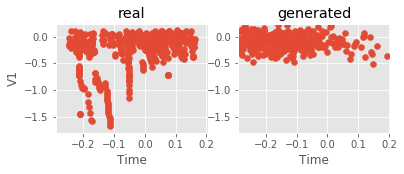

Step: 100 of 5001.
Losses: G, D Gen, D Real, Xgb: 1.1151, 0.5918, 0.7454, 0.9858
D Real - D Gen: 0.1535


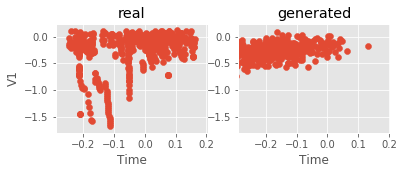

Step: 200 of 5001.
Losses: G, D Gen, D Real, Xgb: 1.1538, 0.5593, 0.6677, 0.9980
D Real - D Gen: 0.1084


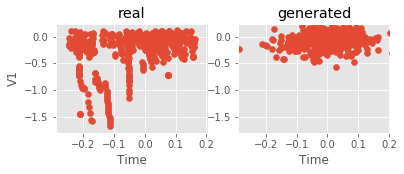

Step: 300 of 5001.
Losses: G, D Gen, D Real, Xgb: 1.0811, 0.6138, 0.8109, 0.9695
D Real - D Gen: 0.1971


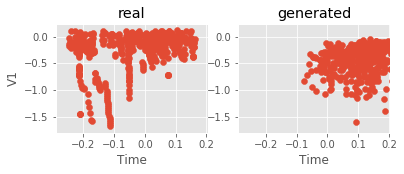

Step: 400 of 5001.
Losses: G, D Gen, D Real, Xgb: 1.2496, 0.4943, 0.5024, 0.9573
D Real - D Gen: 0.0080


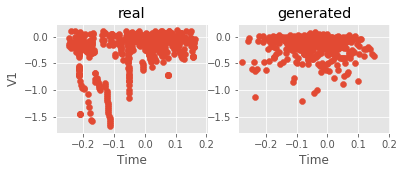

Step: 500 of 5001.
Losses: G, D Gen, D Real, Xgb: 1.0984, 0.6108, 0.6116, 0.9573
D Real - D Gen: 0.0008


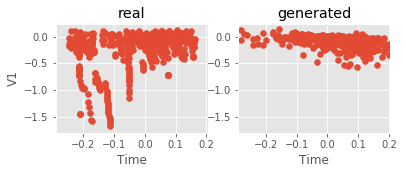

Step: 600 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.8270, 0.8854, 0.6452, 0.9776
D Real - D Gen: -0.2402


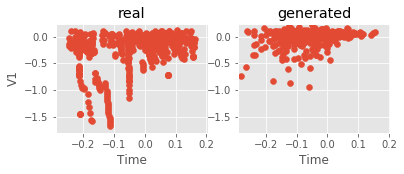

Step: 700 of 5001.
Losses: G, D Gen, D Real, Xgb: 1.2391, 0.5789, 0.5670, 0.9797
D Real - D Gen: -0.0119


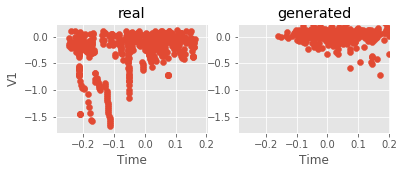

Step: 800 of 5001.
Losses: G, D Gen, D Real, Xgb: 1.0666, 0.5704, 0.6225, 0.9573
D Real - D Gen: 0.0521


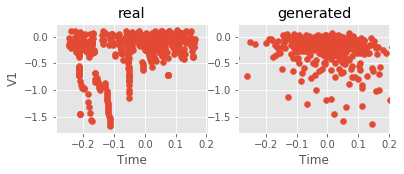

Step: 900 of 5001.
Losses: G, D Gen, D Real, Xgb: 1.2444, 0.5499, 0.6136, 0.9451
D Real - D Gen: 0.0637


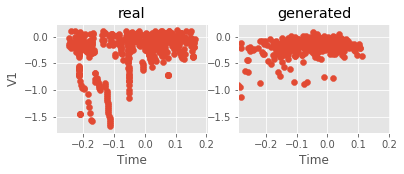

Step: 1000 of 5001.
Losses: G, D Gen, D Real, Xgb: 1.0716, 0.5917, 0.5569, 0.9512
D Real - D Gen: -0.0348


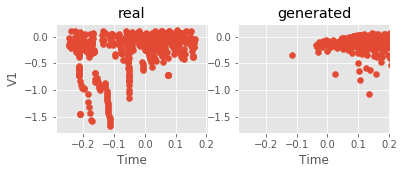

Step: 1100 of 5001.
Losses: G, D Gen, D Real, Xgb: 1.1515, 0.5356, 0.6013, 0.9614
D Real - D Gen: 0.0657


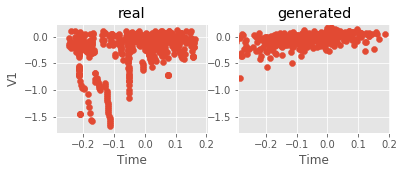

Step: 1200 of 5001.
Losses: G, D Gen, D Real, Xgb: 1.2080, 0.6179, 0.5181, 0.9146
D Real - D Gen: -0.0999


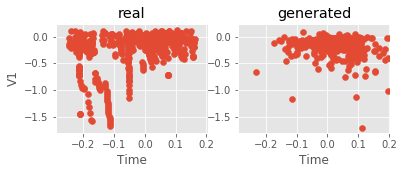

Step: 1300 of 5001.
Losses: G, D Gen, D Real, Xgb: 1.2839, 0.5273, 0.6032, 0.9329
D Real - D Gen: 0.0758


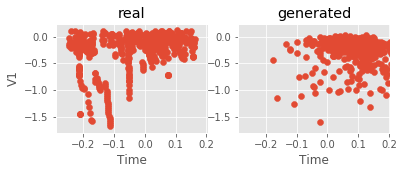

Step: 1400 of 5001.
Losses: G, D Gen, D Real, Xgb: 1.2645, 0.5322, 0.5716, 0.8577
D Real - D Gen: 0.0394


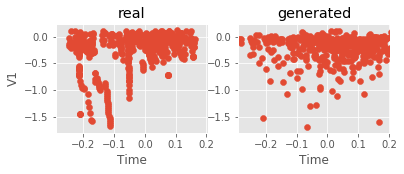

Step: 1500 of 5001.
Losses: G, D Gen, D Real, Xgb: 1.4372, 0.4482, 0.5170, 0.9451
D Real - D Gen: 0.0689


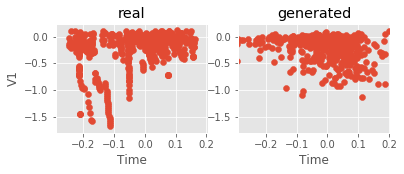

Step: 1600 of 5001.
Losses: G, D Gen, D Real, Xgb: 1.2962, 0.4275, 0.6197, 0.8537
D Real - D Gen: 0.1922


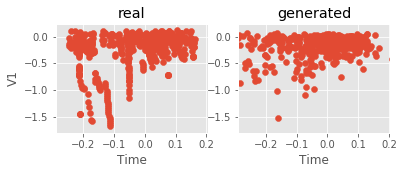

Step: 1700 of 5001.
Losses: G, D Gen, D Real, Xgb: 1.4369, 0.4321, 0.5398, 0.8415
D Real - D Gen: 0.1077


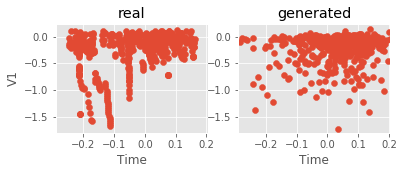

Step: 1800 of 5001.
Losses: G, D Gen, D Real, Xgb: 1.4866, 0.4111, 0.4832, 0.8089
D Real - D Gen: 0.0721


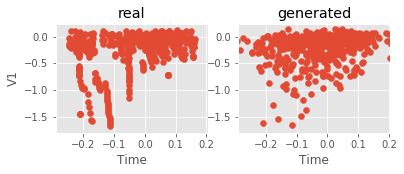

Step: 1900 of 5001.
Losses: G, D Gen, D Real, Xgb: 1.6390, 0.3683, 0.4877, 0.8191
D Real - D Gen: 0.1194


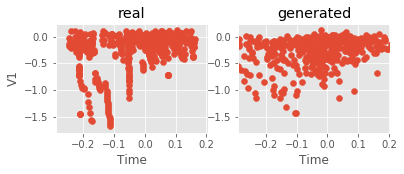

Step: 2000 of 5001.
Losses: G, D Gen, D Real, Xgb: 1.8292, 0.3668, 0.4037, 0.8333
D Real - D Gen: 0.0369


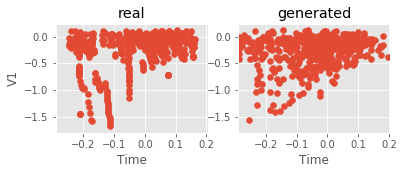

Step: 2100 of 5001.
Losses: G, D Gen, D Real, Xgb: 1.8139, 0.3171, 0.4466, 0.8191
D Real - D Gen: 0.1295


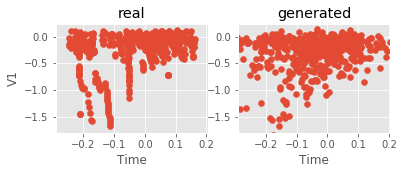

Step: 2200 of 5001.
Losses: G, D Gen, D Real, Xgb: 2.1210, 0.2950, 0.3872, 0.8394
D Real - D Gen: 0.0921


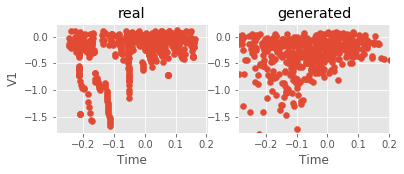

Step: 2300 of 5001.
Losses: G, D Gen, D Real, Xgb: 2.4305, 0.2393, 0.3220, 0.8049
D Real - D Gen: 0.0827


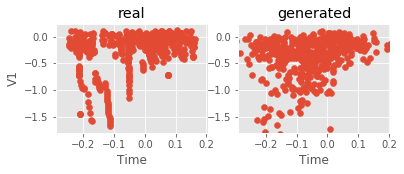

Step: 2400 of 5001.
Losses: G, D Gen, D Real, Xgb: 2.7287, 0.2186, 0.2593, 0.8435
D Real - D Gen: 0.0408


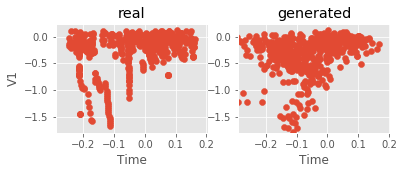

Step: 2500 of 5001.
Losses: G, D Gen, D Real, Xgb: 2.6063, 0.2704, 0.3804, 0.8252
D Real - D Gen: 0.1099


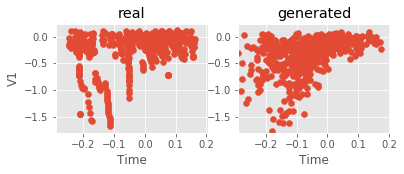

Step: 2600 of 5001.
Losses: G, D Gen, D Real, Xgb: 3.0794, 0.1878, 0.2130, 0.8618
D Real - D Gen: 0.0252


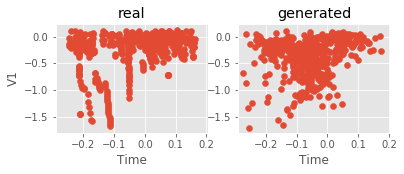

Step: 2700 of 5001.
Losses: G, D Gen, D Real, Xgb: 3.4700, 0.1576, 0.1854, 0.8577
D Real - D Gen: 0.0278


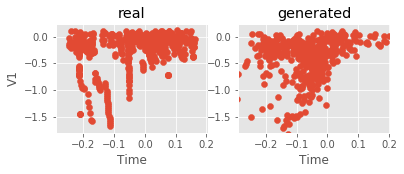

Step: 2800 of 5001.
Losses: G, D Gen, D Real, Xgb: 3.0994, 0.1844, 0.3026, 0.8496
D Real - D Gen: 0.1182


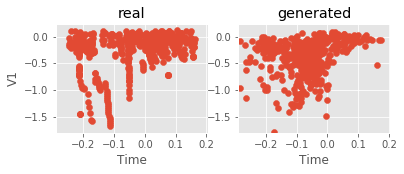

Step: 2900 of 5001.
Losses: G, D Gen, D Real, Xgb: 3.0024, 0.1529, 0.3582, 0.8537
D Real - D Gen: 0.2053


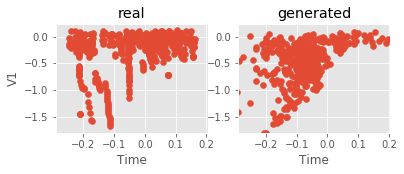

Step: 3000 of 5001.
Losses: G, D Gen, D Real, Xgb: 3.3867, 0.1450, 0.2252, 0.8923
D Real - D Gen: 0.0802


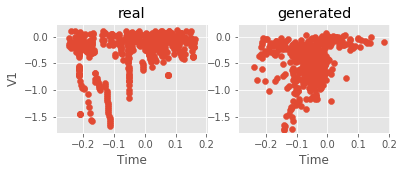

Step: 3100 of 5001.
Losses: G, D Gen, D Real, Xgb: 3.5291, 0.1060, 0.2866, 0.8638
D Real - D Gen: 0.1806


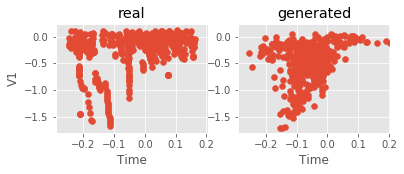

Step: 3200 of 5001.
Losses: G, D Gen, D Real, Xgb: 3.9011, 0.0903, 0.1559, 0.9289
D Real - D Gen: 0.0656


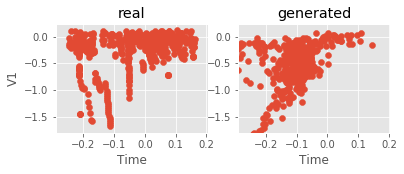

Step: 3300 of 5001.
Losses: G, D Gen, D Real, Xgb: 3.8253, 0.1269, 0.2255, 0.8821
D Real - D Gen: 0.0985


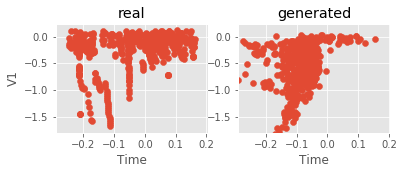

Step: 3400 of 5001.
Losses: G, D Gen, D Real, Xgb: 3.8121, 0.1164, 0.2720, 0.9411
D Real - D Gen: 0.1556


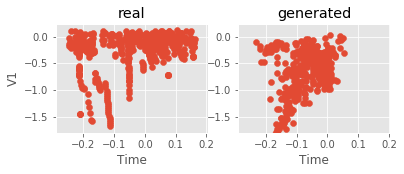

Step: 3500 of 5001.
Losses: G, D Gen, D Real, Xgb: 3.8058, 0.1442, 0.3163, 0.9289
D Real - D Gen: 0.1721


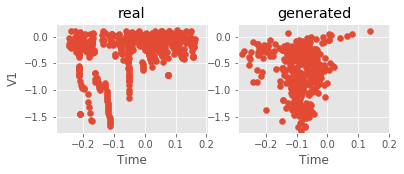

Step: 3600 of 5001.
Losses: G, D Gen, D Real, Xgb: 3.7899, 0.0920, 0.1905, 0.9207
D Real - D Gen: 0.0985


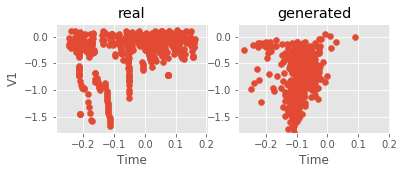

Step: 3700 of 5001.
Losses: G, D Gen, D Real, Xgb: 3.2837, 0.1783, 0.3079, 0.9187
D Real - D Gen: 0.1296


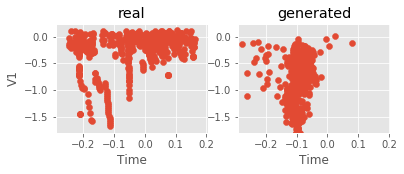

Step: 3800 of 5001.
Losses: G, D Gen, D Real, Xgb: 4.4294, 0.1281, 0.1577, 0.9797
D Real - D Gen: 0.0297


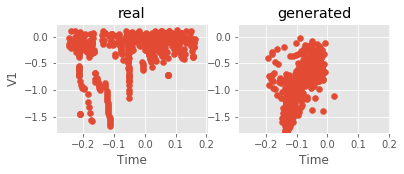

Step: 3900 of 5001.
Losses: G, D Gen, D Real, Xgb: 4.0121, 0.1153, 0.1382, 0.9248
D Real - D Gen: 0.0229


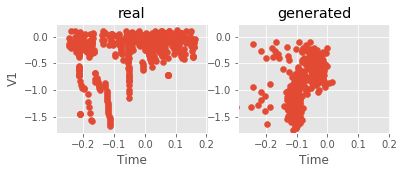

Step: 4000 of 5001.
Losses: G, D Gen, D Real, Xgb: 3.7848, 0.1046, 0.2757, 0.9533
D Real - D Gen: 0.1711


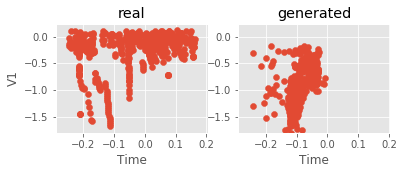

Step: 4100 of 5001.
Losses: G, D Gen, D Real, Xgb: 3.7948, 0.1177, 0.1583, 0.9390
D Real - D Gen: 0.0405


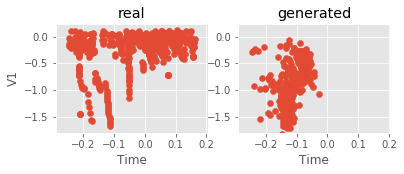

Step: 4200 of 5001.
Losses: G, D Gen, D Real, Xgb: 4.2665, 0.1436, 0.1603, 0.9614
D Real - D Gen: 0.0167


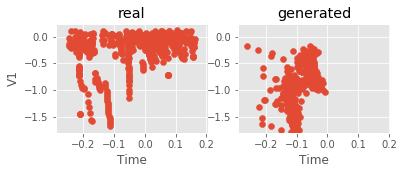

Step: 4300 of 5001.
Losses: G, D Gen, D Real, Xgb: 3.3764, 0.0872, 0.1920, 0.9533
D Real - D Gen: 0.1048


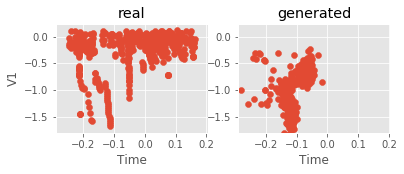

Step: 4400 of 5001.
Losses: G, D Gen, D Real, Xgb: 4.8698, 0.0917, 0.1892, 0.9573
D Real - D Gen: 0.0976


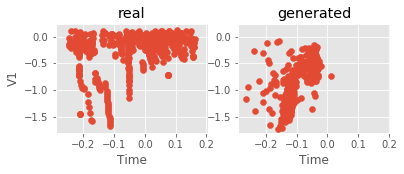

Step: 4500 of 5001.
Losses: G, D Gen, D Real, Xgb: 3.5957, 0.0819, 0.2532, 0.9472
D Real - D Gen: 0.1712


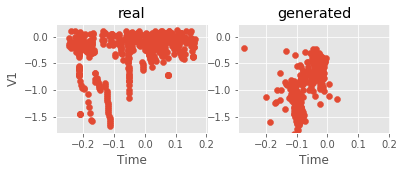

Step: 4600 of 5001.
Losses: G, D Gen, D Real, Xgb: 3.9549, 0.0589, 0.1864, 0.9512
D Real - D Gen: 0.1275


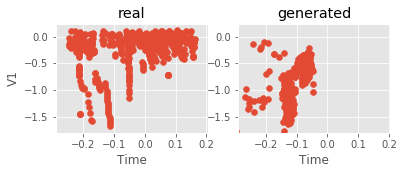

Step: 4700 of 5001.
Losses: G, D Gen, D Real, Xgb: 3.4477, 0.0755, 0.2732, 0.9492
D Real - D Gen: 0.1977


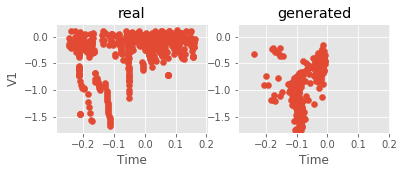

Step: 4800 of 5001.
Losses: G, D Gen, D Real, Xgb: 3.6098, 0.0816, 0.2057, 0.9390
D Real - D Gen: 0.1241


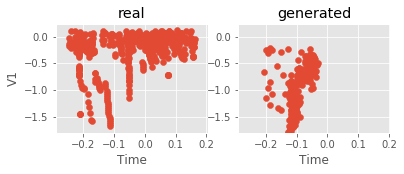

Step: 4900 of 5001.
Losses: G, D Gen, D Real, Xgb: 4.3864, 0.1235, 0.1715, 0.9533
D Real - D Gen: 0.0481


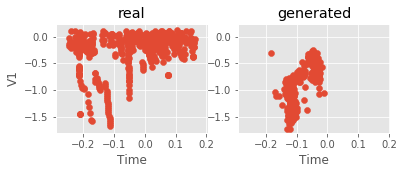

Step: 5000 of 5001.
Losses: G, D Gen, D Real, Xgb: 3.8726, 0.0575, 0.2377, 0.9593
D Real - D Gen: 0.1802


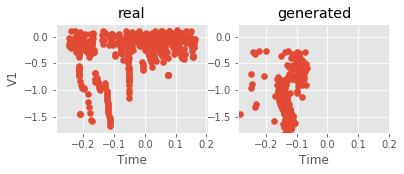

('data_dim: ', 30)
('data_cols: ', ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'])
('label_dim: ', 1)
('label_cols: ', ['Class'])
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 33)           0           input_3[0][0]                    
                  

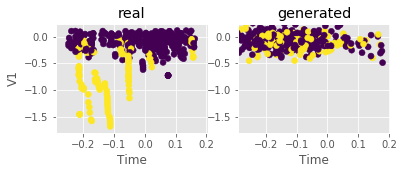

Step: 100 of 5001.
Losses: G, D Gen, D Real, Xgb: 1.3941, 0.6140, 0.6247, 0.9980
D Real - D Gen: 0.0107


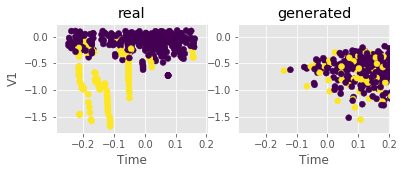

Step: 200 of 5001.
Losses: G, D Gen, D Real, Xgb: 1.3684, 0.4887, 0.6506, 0.9817
D Real - D Gen: 0.1619


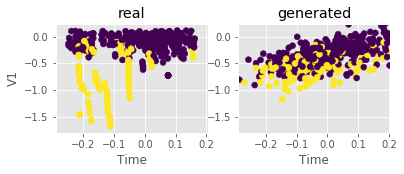

Step: 300 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.9209, 0.7300, 0.6197, 0.9919
D Real - D Gen: -0.1103


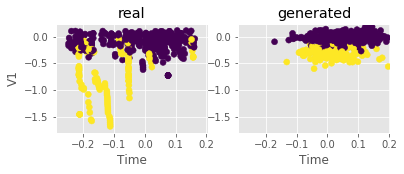

Step: 400 of 5001.
Losses: G, D Gen, D Real, Xgb: 1.0405, 0.5959, 0.5242, 0.9654
D Real - D Gen: -0.0717


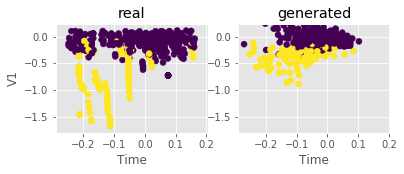

Step: 500 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.9274, 0.6804, 0.5569, 0.9858
D Real - D Gen: -0.1235


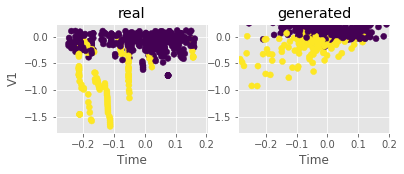

Step: 600 of 5001.
Losses: G, D Gen, D Real, Xgb: 1.0114, 0.6578, 0.5830, 0.9776
D Real - D Gen: -0.0748


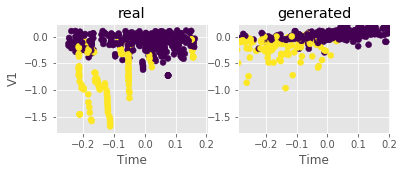

Step: 700 of 5001.
Losses: G, D Gen, D Real, Xgb: 1.1091, 0.5231, 0.6412, 0.9593
D Real - D Gen: 0.1182


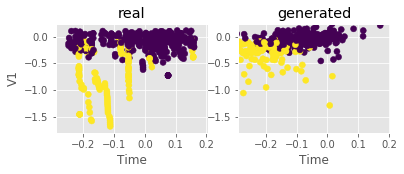

Step: 800 of 5001.
Losses: G, D Gen, D Real, Xgb: 1.0645, 0.5406, 0.5767, 0.9329
D Real - D Gen: 0.0361


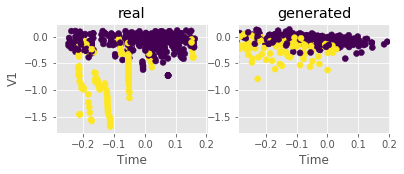

Step: 900 of 5001.
Losses: G, D Gen, D Real, Xgb: 1.1426, 0.5103, 0.5681, 0.9593
D Real - D Gen: 0.0577


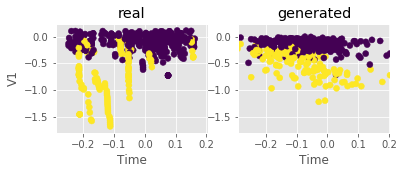

Step: 1000 of 5001.
Losses: G, D Gen, D Real, Xgb: 1.2554, 0.4979, 0.5515, 0.9431
D Real - D Gen: 0.0536


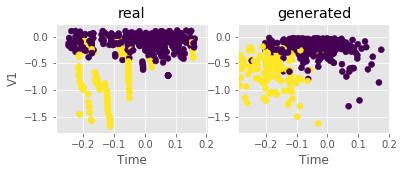

Step: 1100 of 5001.
Losses: G, D Gen, D Real, Xgb: 1.2990, 0.4447, 0.5272, 0.9512
D Real - D Gen: 0.0825


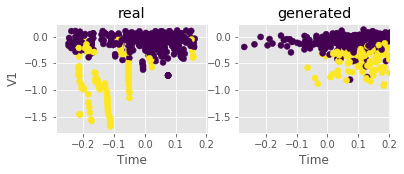

Step: 1200 of 5001.
Losses: G, D Gen, D Real, Xgb: 1.1755, 0.5601, 0.4736, 0.8841
D Real - D Gen: -0.0866


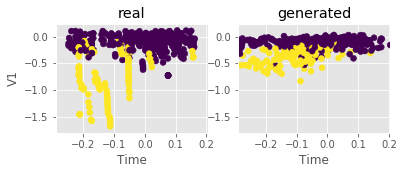

Step: 1300 of 5001.
Losses: G, D Gen, D Real, Xgb: 1.2968, 0.4551, 0.5955, 0.8923
D Real - D Gen: 0.1404


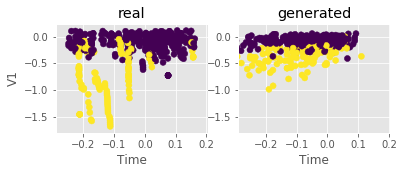

Step: 1400 of 5001.
Losses: G, D Gen, D Real, Xgb: 1.3810, 0.4075, 0.5899, 0.8252
D Real - D Gen: 0.1823


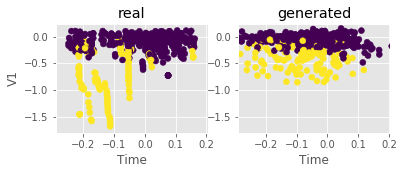

Step: 1500 of 5001.
Losses: G, D Gen, D Real, Xgb: 1.5064, 0.3918, 0.4724, 0.8618
D Real - D Gen: 0.0806


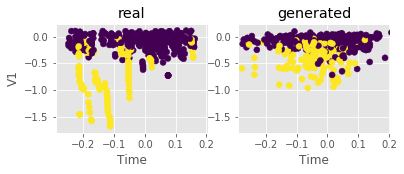

Step: 1600 of 5001.
Losses: G, D Gen, D Real, Xgb: 1.5410, 0.3735, 0.4809, 0.8069
D Real - D Gen: 0.1074


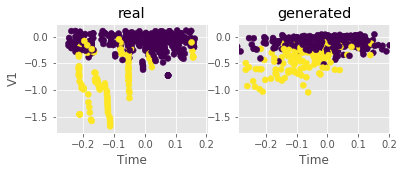

Step: 1700 of 5001.
Losses: G, D Gen, D Real, Xgb: 1.7793, 0.3539, 0.3526, 0.7927
D Real - D Gen: -0.0012


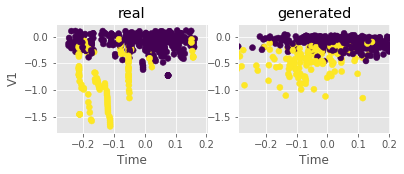

Step: 1800 of 5001.
Losses: G, D Gen, D Real, Xgb: 1.9773, 0.2701, 0.3579, 0.8272
D Real - D Gen: 0.0878


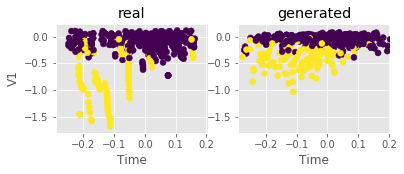

Step: 1900 of 5001.
Losses: G, D Gen, D Real, Xgb: 2.0278, 0.3188, 0.3745, 0.8211
D Real - D Gen: 0.0557


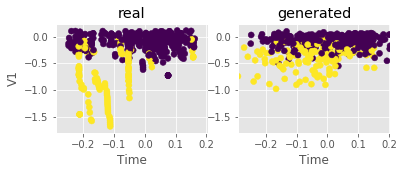

Step: 2000 of 5001.
Losses: G, D Gen, D Real, Xgb: 2.1966, 0.2796, 0.3355, 0.8191
D Real - D Gen: 0.0559


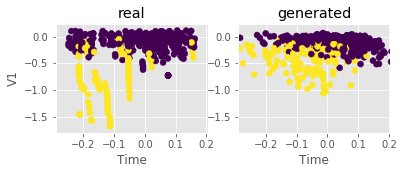

Step: 2100 of 5001.
Losses: G, D Gen, D Real, Xgb: 2.5057, 0.2494, 0.2951, 0.8069
D Real - D Gen: 0.0457


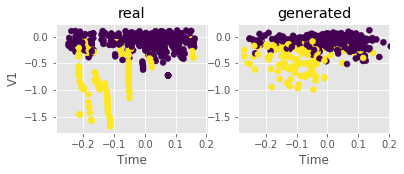

Step: 2200 of 5001.
Losses: G, D Gen, D Real, Xgb: 2.9872, 0.2082, 0.3088, 0.8252
D Real - D Gen: 0.1006


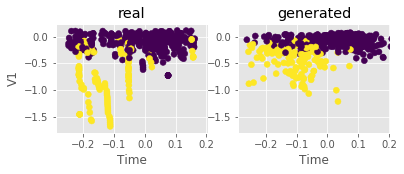

Step: 2300 of 5001.
Losses: G, D Gen, D Real, Xgb: 2.9435, 0.2033, 0.2652, 0.8333
D Real - D Gen: 0.0619


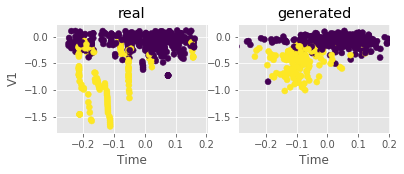

Step: 2400 of 5001.
Losses: G, D Gen, D Real, Xgb: 3.2158, 0.1564, 0.2017, 0.8415
D Real - D Gen: 0.0453


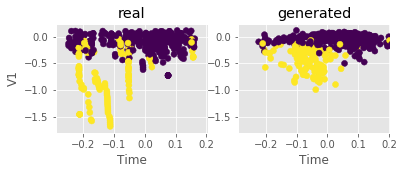

Step: 2500 of 5001.
Losses: G, D Gen, D Real, Xgb: 3.4247, 0.2113, 0.2368, 0.8354
D Real - D Gen: 0.0255


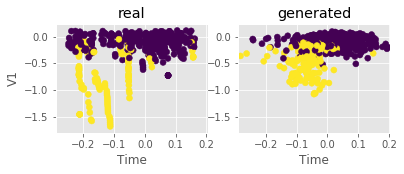

Step: 2600 of 5001.
Losses: G, D Gen, D Real, Xgb: 3.9014, 0.1173, 0.1371, 0.8313
D Real - D Gen: 0.0197


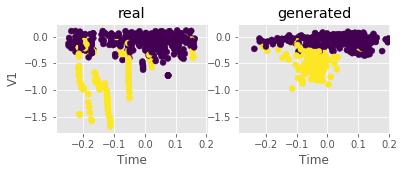

Step: 2700 of 5001.
Losses: G, D Gen, D Real, Xgb: 4.0267, 0.1202, 0.1333, 0.8272
D Real - D Gen: 0.0131


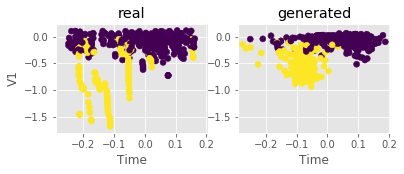

Step: 2800 of 5001.
Losses: G, D Gen, D Real, Xgb: 4.1664, 0.0963, 0.1318, 0.8699
D Real - D Gen: 0.0355


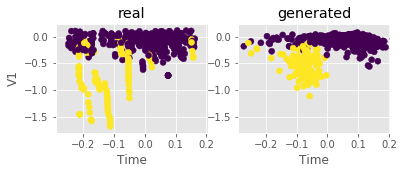

Step: 2900 of 5001.
Losses: G, D Gen, D Real, Xgb: 4.8597, 0.0795, 0.1604, 0.8699
D Real - D Gen: 0.0809


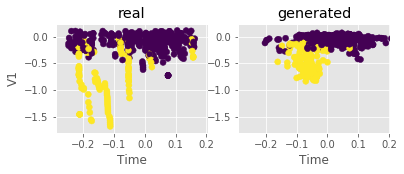

Step: 3000 of 5001.
Losses: G, D Gen, D Real, Xgb: 5.3212, 0.1123, 0.1121, 0.8476
D Real - D Gen: -0.0001


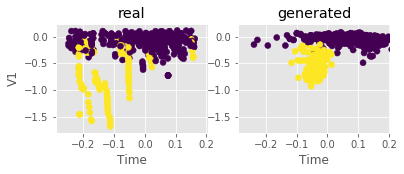

Step: 3100 of 5001.
Losses: G, D Gen, D Real, Xgb: 5.3924, 0.1016, 0.1108, 0.8801
D Real - D Gen: 0.0092


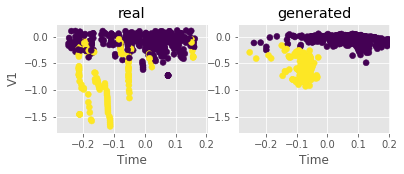

Step: 3200 of 5001.
Losses: G, D Gen, D Real, Xgb: 5.4893, 0.0866, 0.1012, 0.8801
D Real - D Gen: 0.0145


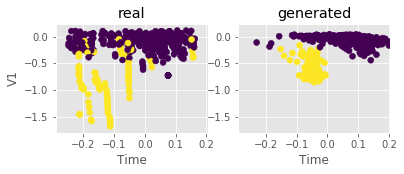

Step: 3300 of 5001.
Losses: G, D Gen, D Real, Xgb: 6.4836, 0.0965, 0.0966, 0.8821
D Real - D Gen: 0.0001


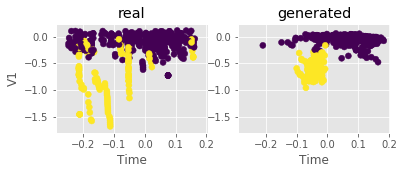

Step: 3400 of 5001.
Losses: G, D Gen, D Real, Xgb: 5.4687, 0.1269, 0.1725, 0.8720
D Real - D Gen: 0.0456


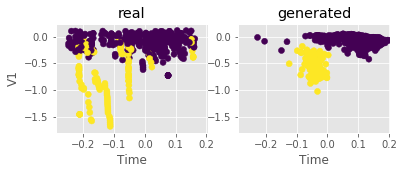

Step: 3500 of 5001.
Losses: G, D Gen, D Real, Xgb: 5.5755, 0.0634, 0.0910, 0.9228
D Real - D Gen: 0.0276


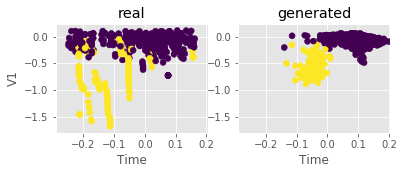

Step: 3600 of 5001.
Losses: G, D Gen, D Real, Xgb: 4.7091, 0.1167, 0.3022, 0.8862
D Real - D Gen: 0.1855


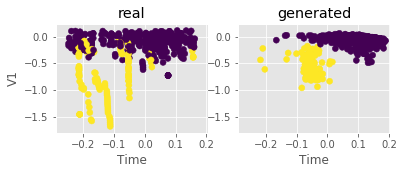

Step: 3700 of 5001.
Losses: G, D Gen, D Real, Xgb: 5.0687, 0.0896, 0.2896, 0.9065
D Real - D Gen: 0.2000


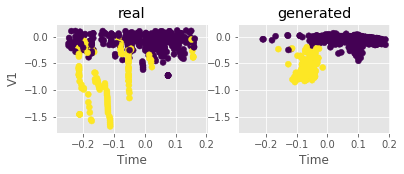

Step: 3800 of 5001.
Losses: G, D Gen, D Real, Xgb: 4.7879, 0.0938, 0.1800, 0.9350
D Real - D Gen: 0.0862


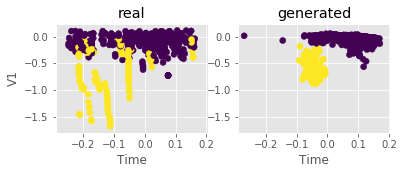

Step: 3900 of 5001.
Losses: G, D Gen, D Real, Xgb: 4.5483, 0.0955, 0.2523, 0.8841
D Real - D Gen: 0.1567


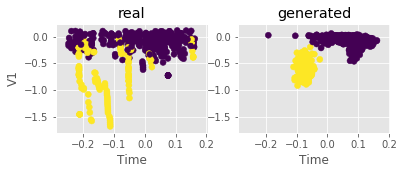

Step: 4000 of 5001.
Losses: G, D Gen, D Real, Xgb: 5.0759, 0.1114, 0.1550, 0.9289
D Real - D Gen: 0.0435


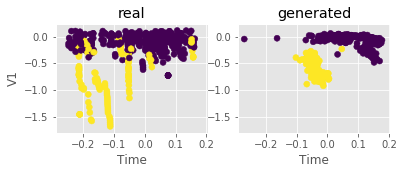

Step: 4100 of 5001.
Losses: G, D Gen, D Real, Xgb: 4.5943, 0.0818, 0.1251, 0.9228
D Real - D Gen: 0.0433


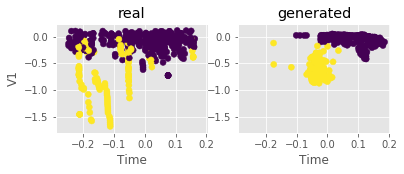

Step: 4200 of 5001.
Losses: G, D Gen, D Real, Xgb: 4.5862, 0.0722, 0.2115, 0.9146
D Real - D Gen: 0.1393


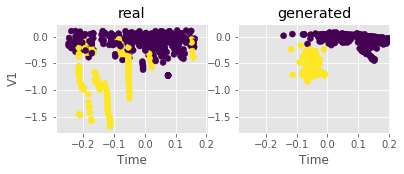

Step: 4300 of 5001.
Losses: G, D Gen, D Real, Xgb: 4.0720, 0.0550, 0.2408, 0.9065
D Real - D Gen: 0.1858


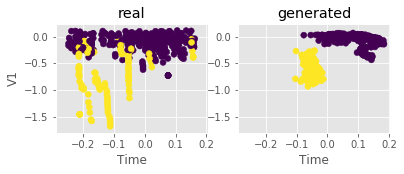

Step: 4400 of 5001.
Losses: G, D Gen, D Real, Xgb: 4.2276, 0.0886, 0.1612, 0.9472
D Real - D Gen: 0.0726


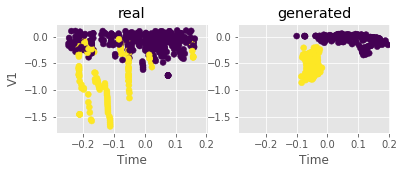

Step: 4500 of 5001.
Losses: G, D Gen, D Real, Xgb: 4.7319, 0.1216, 0.1891, 0.9268
D Real - D Gen: 0.0675


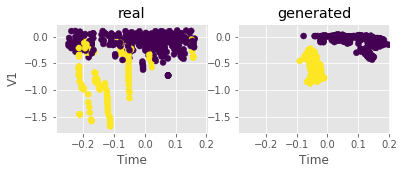

Step: 4600 of 5001.
Losses: G, D Gen, D Real, Xgb: 4.4921, 0.0635, 0.2051, 0.8821
D Real - D Gen: 0.1416


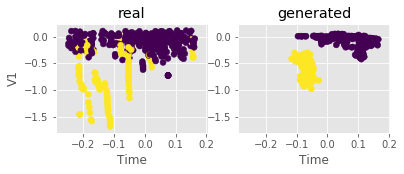

Step: 4700 of 5001.
Losses: G, D Gen, D Real, Xgb: 4.5526, 0.0536, 0.1680, 0.9106
D Real - D Gen: 0.1145


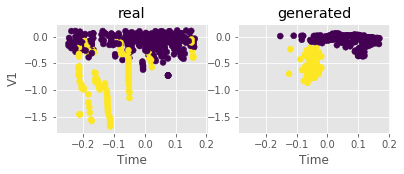

Step: 4800 of 5001.
Losses: G, D Gen, D Real, Xgb: 4.1419, 0.0938, 0.1643, 0.9146
D Real - D Gen: 0.0705


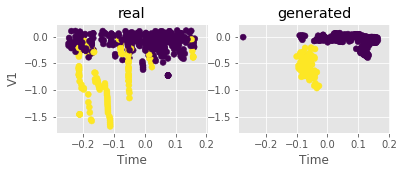

Step: 4900 of 5001.
Losses: G, D Gen, D Real, Xgb: 4.7861, 0.0393, 0.1723, 0.9167
D Real - D Gen: 0.1330


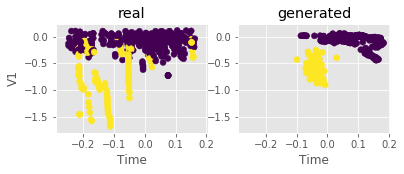

Step: 5000 of 5001.
Losses: G, D Gen, D Real, Xgb: 4.3535, 0.0584, 0.0747, 0.9268
D Real - D Gen: 0.0163


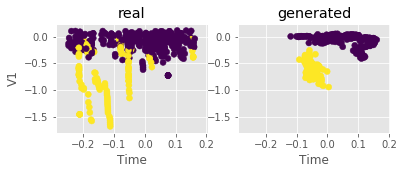

CPU times: user 11min 32s, sys: 1min 18s, total: 12min 51s
Wall time: 4min 1s


In [13]:
%%time
# Training the vanilla GAN and CGAN architectures
arguments = [rand_dim, nb_steps, batch_size, 
             k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
            data_dir, generator_model_path, discriminator_model_path, loss_pickle_path, show ]

adversarial_training_GAN(arguments, train_no_label, data_cols ) # GAN
adversarial_training_GAN(arguments, train, data_cols=data_cols, label_cols=label_cols ) # CGAN

('data_dim: ', 30)
('data_cols: ', ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'])
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               4224      
_________________________________________________________________
dense_18 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_19 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_20 (Dense)             (None, 30)                15390     
Total params: 184,222
Trainable 

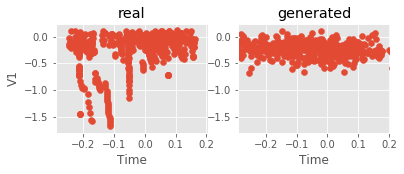

Step: 100 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0329, 0.0482, 0.0780, 0.9898
D Real - D Gen: 0.0298


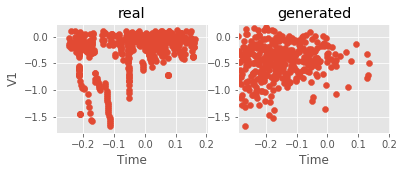

Step: 200 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0189, -0.0139, 0.0259, 0.9553
D Real - D Gen: 0.0398


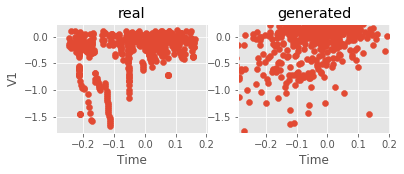

Step: 300 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0331, -0.0371, -0.0161, 0.9634
D Real - D Gen: 0.0211


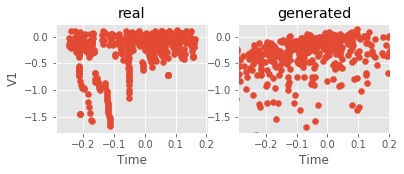

Step: 400 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0419, -0.0177, 0.0158, 0.9390
D Real - D Gen: 0.0336


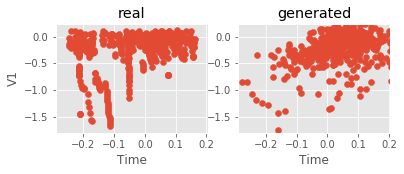

Step: 500 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0170, 0.0116, 0.0299, 0.9268
D Real - D Gen: 0.0182


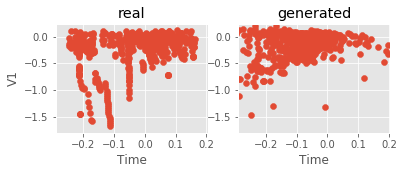

Step: 600 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0139, 0.0165, 0.0150, 0.9350
D Real - D Gen: -0.0014


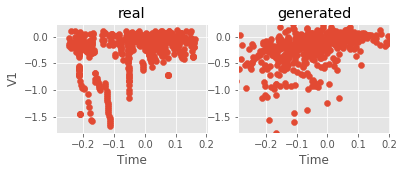

Step: 700 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0126, -0.0140, -0.0074, 0.9106
D Real - D Gen: 0.0067


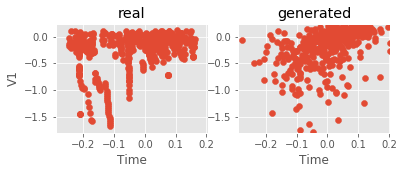

Step: 800 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0084, 0.0185, 0.0258, 0.9573
D Real - D Gen: 0.0073


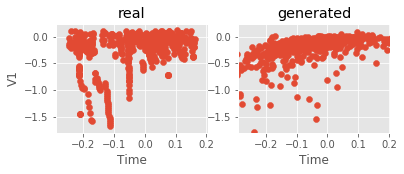

Step: 900 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0209, -0.0028, -0.0046, 0.9695
D Real - D Gen: -0.0017


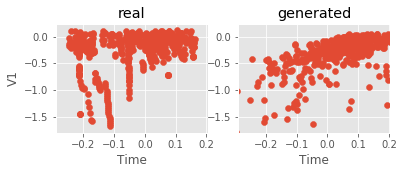

Step: 1000 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0160, -0.0262, -0.0245, 0.9146
D Real - D Gen: 0.0017


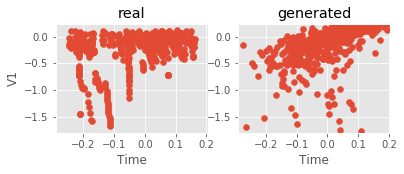

Step: 1100 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0179, -0.0341, -0.0243, 0.8984
D Real - D Gen: 0.0098


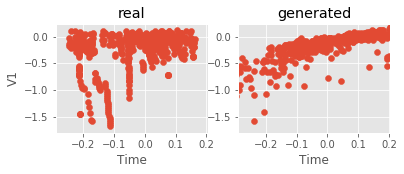

Step: 1200 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0187, -0.0261, -0.0158, 0.9654
D Real - D Gen: 0.0103


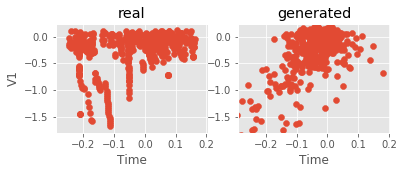

Step: 1300 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0251, -0.0347, -0.0164, 0.9309
D Real - D Gen: 0.0183


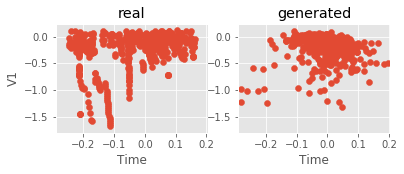

Step: 1400 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0295, 0.0010, 0.0091, 0.9187
D Real - D Gen: 0.0081


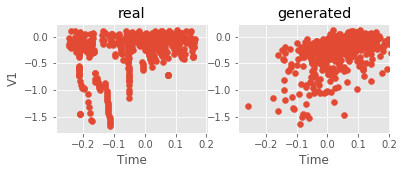

Step: 1500 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0087, -0.0045, 0.0057, 0.9736
D Real - D Gen: 0.0103


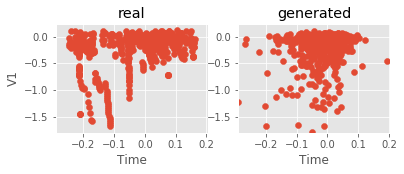

Step: 1600 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0970, -0.0797, -0.0620, 0.9289
D Real - D Gen: 0.0178


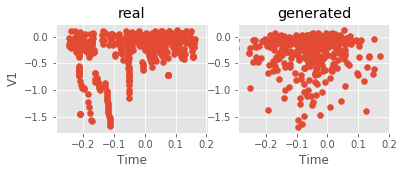

Step: 1700 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0337, -0.0373, -0.0042, 0.9146
D Real - D Gen: 0.0330


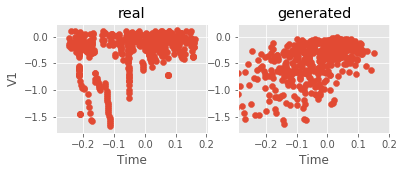

Step: 1800 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0434, -0.0457, -0.0306, 0.9309
D Real - D Gen: 0.0150


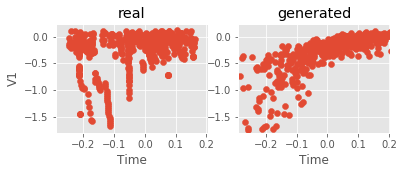

Step: 1900 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0703, -0.0607, -0.0749, 0.9126
D Real - D Gen: -0.0142


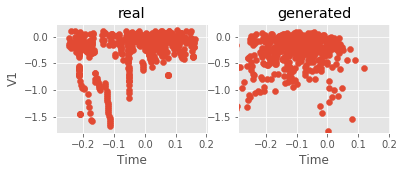

Step: 2000 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.1117, -0.1122, -0.0852, 0.8780
D Real - D Gen: 0.0271


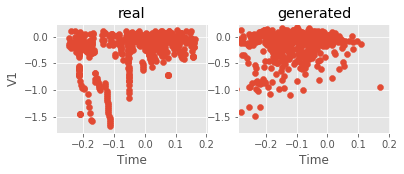

Step: 2100 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.1510, -0.1460, -0.1345, 0.9146
D Real - D Gen: 0.0115


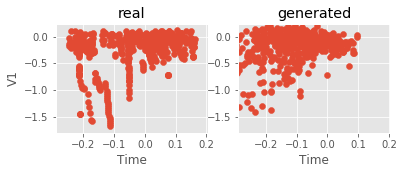

Step: 2200 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.1657, -0.1354, -0.1122, 0.8882
D Real - D Gen: 0.0233


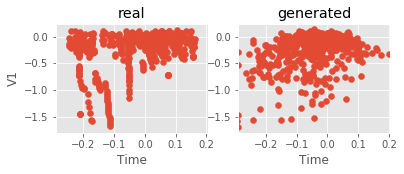

Step: 2300 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.1435, -0.1242, -0.1041, 0.8862
D Real - D Gen: 0.0201


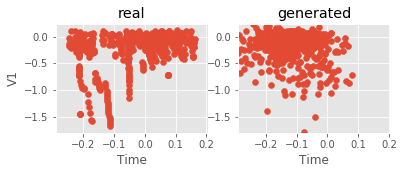

Step: 2400 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.1332, -0.1436, -0.1339, 0.8801
D Real - D Gen: 0.0097


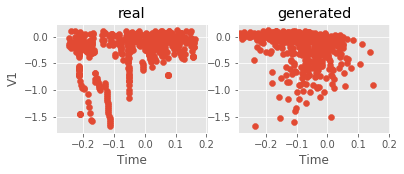

Step: 2500 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.1265, -0.1106, -0.1035, 0.8923
D Real - D Gen: 0.0071


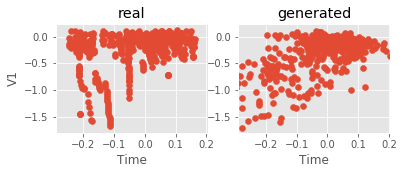

Step: 2600 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.1125, -0.1153, -0.0958, 0.8963
D Real - D Gen: 0.0195


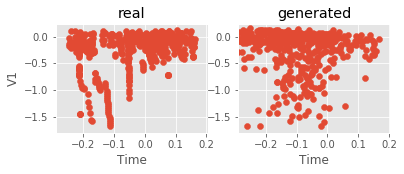

Step: 2700 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0909, -0.0991, -0.0799, 0.8801
D Real - D Gen: 0.0192


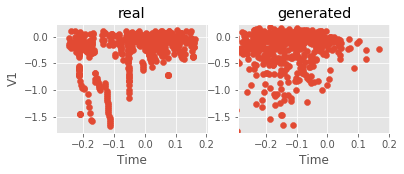

Step: 2800 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0631, -0.0639, -0.0571, 0.8984
D Real - D Gen: 0.0069


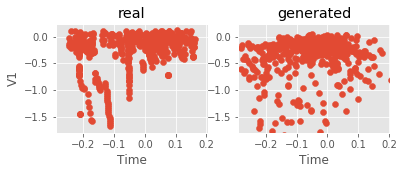

Step: 2900 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0887, -0.0791, -0.0663, 0.8902
D Real - D Gen: 0.0128


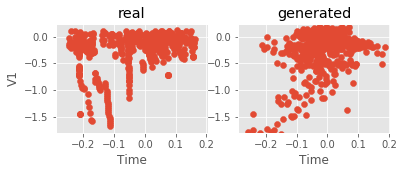

Step: 3000 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0990, -0.1077, -0.0951, 0.8720
D Real - D Gen: 0.0126


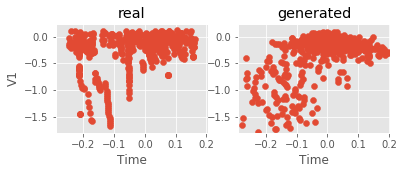

Step: 3100 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0889, -0.0816, -0.0840, 0.9085
D Real - D Gen: -0.0024


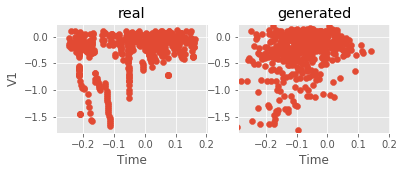

Step: 3200 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.1072, -0.1040, -0.0951, 0.8821
D Real - D Gen: 0.0089


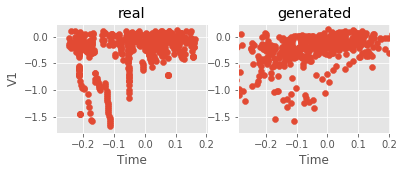

Step: 3300 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.1097, -0.1003, -0.0831, 0.8963
D Real - D Gen: 0.0172


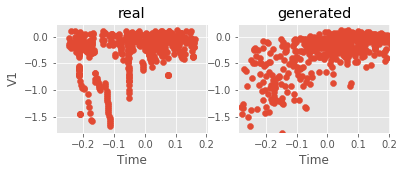

Step: 3400 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.1249, -0.1162, -0.1020, 0.8679
D Real - D Gen: 0.0142


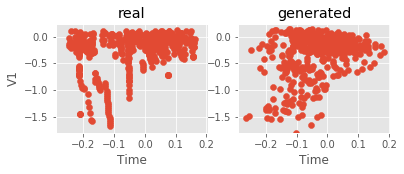

Step: 3500 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.1070, -0.1188, -0.1035, 0.9146
D Real - D Gen: 0.0152


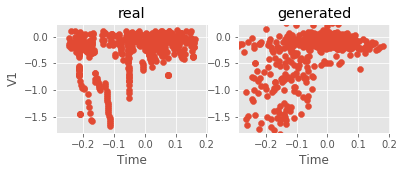

Step: 3600 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.1013, -0.0963, -0.0895, 0.9004
D Real - D Gen: 0.0068


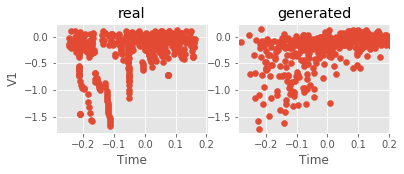

Step: 3700 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.1144, -0.1062, -0.0897, 0.8882
D Real - D Gen: 0.0165


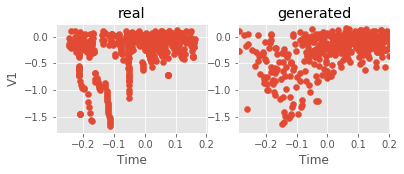

Step: 3800 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.1227, -0.1136, -0.0943, 0.8943
D Real - D Gen: 0.0193


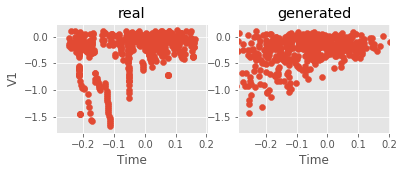

Step: 3900 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.1873, -0.1668, -0.1165, 0.8659
D Real - D Gen: 0.0503


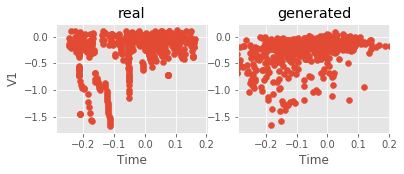

Step: 4000 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.1326, -0.1296, -0.1265, 0.8557
D Real - D Gen: 0.0031


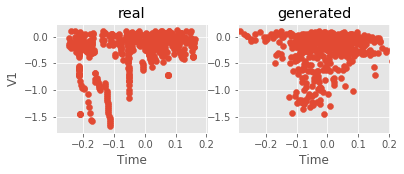

Step: 4100 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.1208, -0.1184, -0.1071, 0.9085
D Real - D Gen: 0.0113


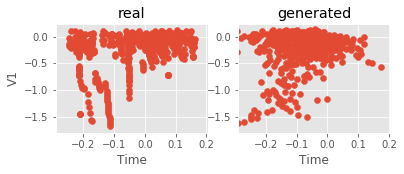

Step: 4200 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.1248, -0.1215, -0.1129, 0.8333
D Real - D Gen: 0.0086


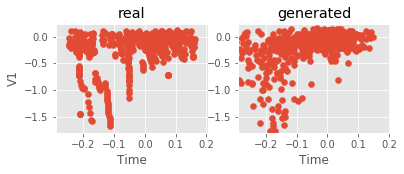

Step: 4300 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.1295, -0.1212, -0.1123, 0.8699
D Real - D Gen: 0.0089


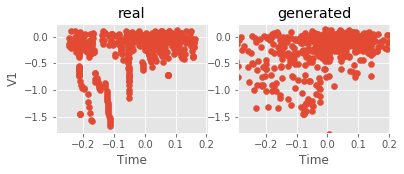

Step: 4400 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.1097, -0.1128, -0.0991, 0.8394
D Real - D Gen: 0.0138


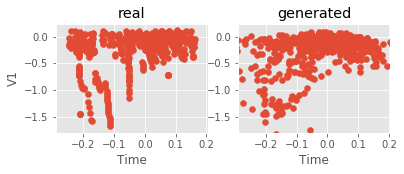

Step: 4500 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.1094, -0.1157, -0.1007, 0.8354
D Real - D Gen: 0.0150


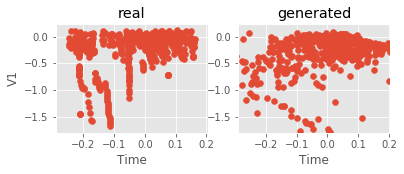

Step: 4600 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.1278, -0.1316, -0.1167, 0.8516
D Real - D Gen: 0.0149


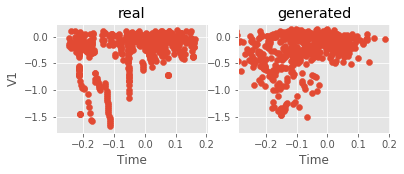

Step: 4700 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.1183, -0.1050, -0.0974, 0.8780
D Real - D Gen: 0.0076


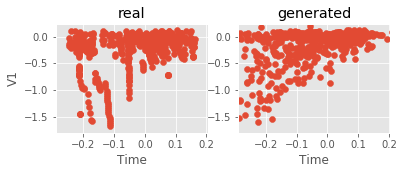

Step: 4800 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.1273, -0.1243, -0.1140, 0.8902
D Real - D Gen: 0.0103


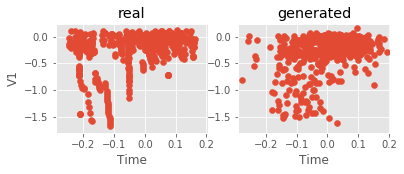

Step: 4900 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.1162, -0.1053, -0.0885, 0.8740
D Real - D Gen: 0.0168


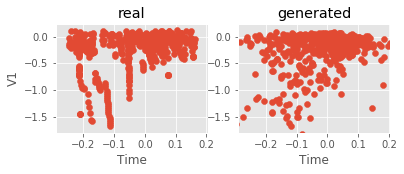

Step: 5000 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.1161, -0.1119, -0.0955, 0.8679
D Real - D Gen: 0.0164


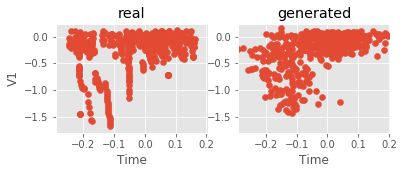

('data_dim: ', 30)
('data_cols: ', ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'])
('label_dim: ', 1)
('label_cols: ', ['Class'])
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 33)           0           input_8[0][0]                    
                  

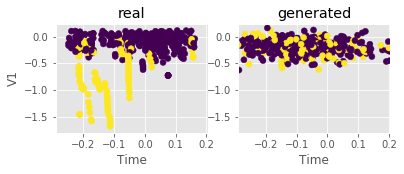

Step: 100 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0449, 0.0640, 0.1105, 0.9817
D Real - D Gen: 0.0466


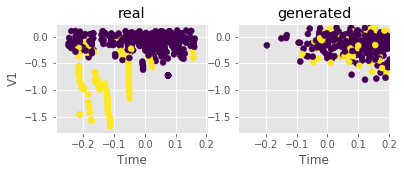

Step: 200 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0835, -0.0710, -0.0203, 0.9431
D Real - D Gen: 0.0507


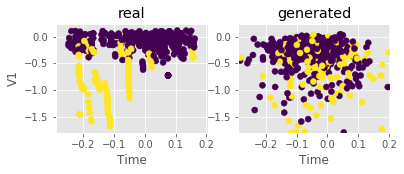

Step: 300 of 5001.
Losses: G, D Gen, D Real, Xgb: -0.0410, 0.0253, 0.0455, 0.9533
D Real - D Gen: 0.0202


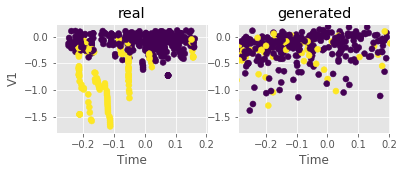

Step: 400 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0221, -0.0112, 0.0124, 0.9045
D Real - D Gen: 0.0237


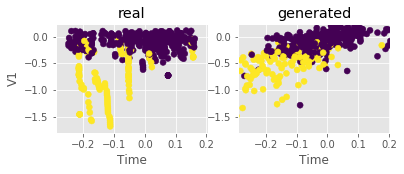

Step: 500 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0372, -0.0348, -0.0287, 0.9533
D Real - D Gen: 0.0061


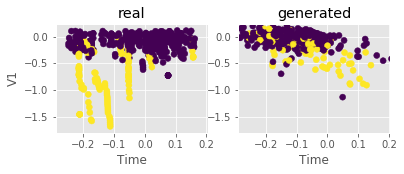

Step: 600 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0738, -0.0699, -0.0315, 0.9695
D Real - D Gen: 0.0384


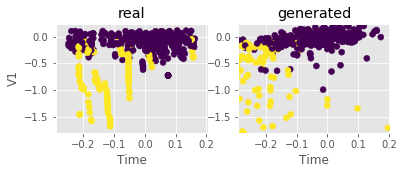

Step: 700 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0426, -0.0387, -0.0107, 0.9533
D Real - D Gen: 0.0280


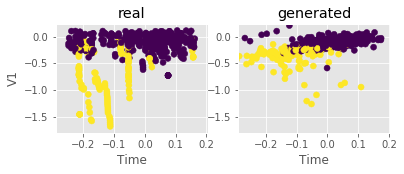

Step: 800 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0689, -0.0673, -0.0504, 0.9634
D Real - D Gen: 0.0168


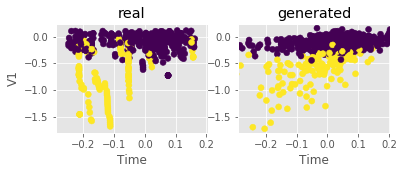

Step: 900 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0632, -0.0394, -0.0387, 0.9350
D Real - D Gen: 0.0007


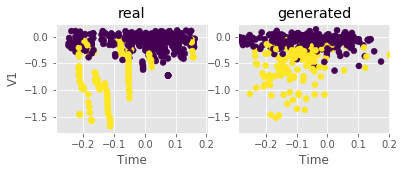

Step: 1000 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0294, -0.0339, -0.0047, 0.9085
D Real - D Gen: 0.0292


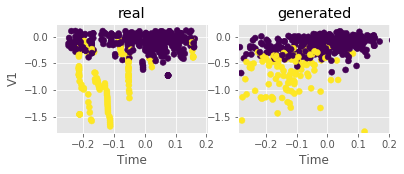

Step: 1100 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0850, -0.0732, -0.0669, 0.9573
D Real - D Gen: 0.0063


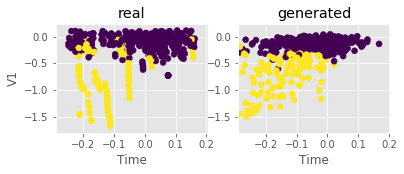

Step: 1200 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0324, -0.0383, -0.0257, 0.9167
D Real - D Gen: 0.0126


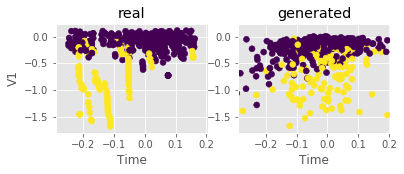

Step: 1300 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0771, -0.0780, -0.0668, 0.9004
D Real - D Gen: 0.0112


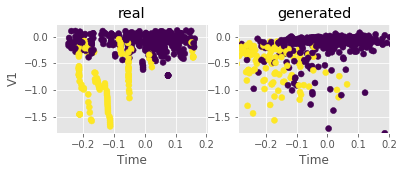

Step: 1400 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0775, -0.0628, -0.0564, 0.9451
D Real - D Gen: 0.0064


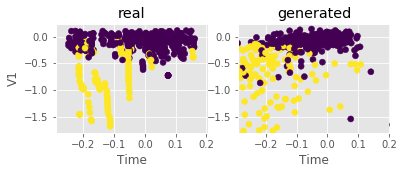

Step: 1500 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.1268, -0.1218, -0.1189, 0.9228
D Real - D Gen: 0.0030


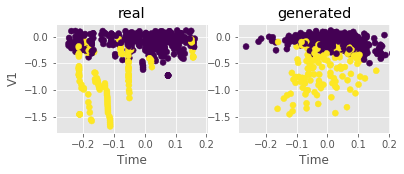

Step: 1600 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0728, -0.0691, -0.0616, 0.9553
D Real - D Gen: 0.0075


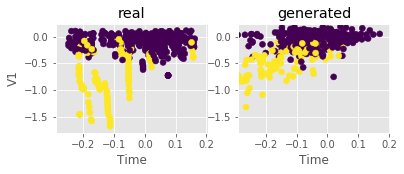

Step: 1700 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0591, -0.0623, -0.0509, 0.9329
D Real - D Gen: 0.0114


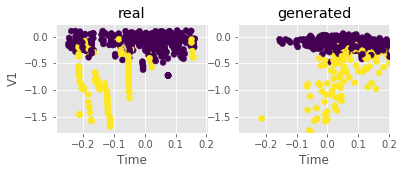

Step: 1800 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0762, -0.0514, -0.0340, 0.9553
D Real - D Gen: 0.0175


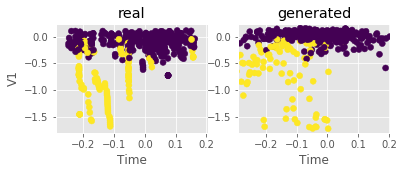

Step: 1900 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0676, -0.0736, -0.0748, 0.9187
D Real - D Gen: -0.0012


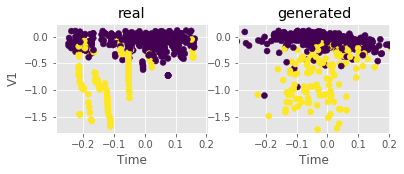

Step: 2000 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0804, -0.0830, -0.0714, 0.8801
D Real - D Gen: 0.0115


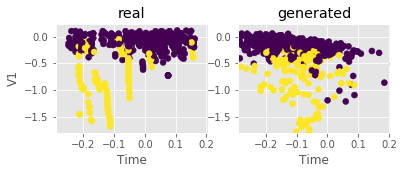

Step: 2100 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.1570, -0.1123, -0.0889, 0.9167
D Real - D Gen: 0.0235


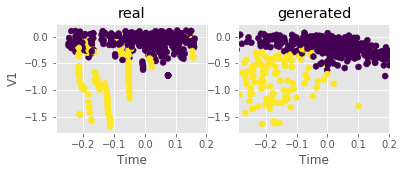

Step: 2200 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0812, -0.0782, -0.0736, 0.8780
D Real - D Gen: 0.0046


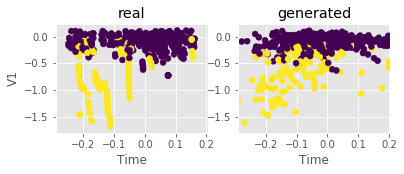

Step: 2300 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0633, -0.0743, -0.0695, 0.9350
D Real - D Gen: 0.0047


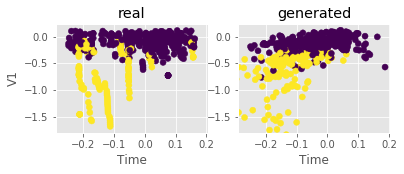

Step: 2400 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0492, -0.0312, -0.0267, 0.8780
D Real - D Gen: 0.0046


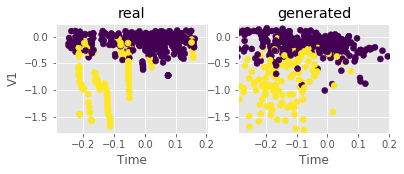

Step: 2500 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0478, -0.0516, -0.0266, 0.8902
D Real - D Gen: 0.0251


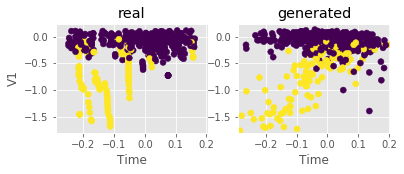

Step: 2600 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0776, -0.0707, -0.0685, 0.9492
D Real - D Gen: 0.0022


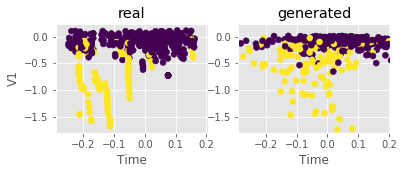

Step: 2700 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.1084, -0.1083, -0.0896, 0.9004
D Real - D Gen: 0.0187


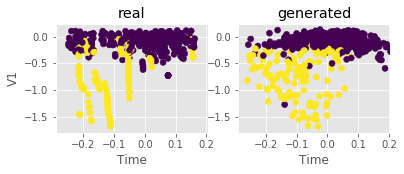

Step: 2800 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0800, -0.0777, -0.0662, 0.9065
D Real - D Gen: 0.0114


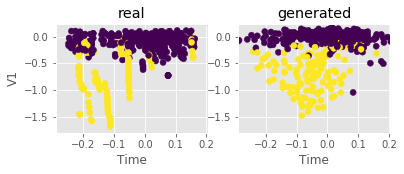

Step: 2900 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0566, -0.0720, -0.0588, 0.8455
D Real - D Gen: 0.0131


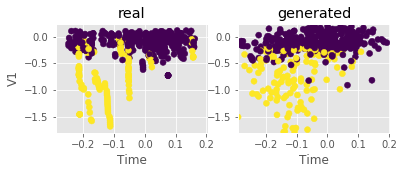

Step: 3000 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0893, -0.0838, -0.0821, 0.9268
D Real - D Gen: 0.0017


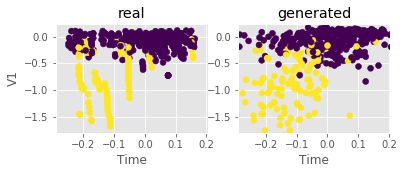

Step: 3100 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0545, -0.0600, -0.0702, 0.8780
D Real - D Gen: -0.0101


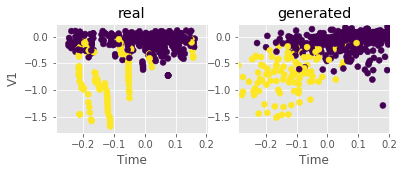

Step: 3200 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0962, -0.0990, -0.0830, 0.8841
D Real - D Gen: 0.0160


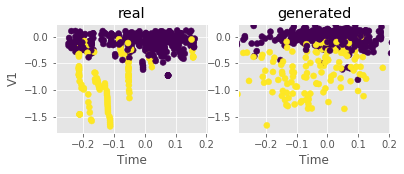

Step: 3300 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.1251, -0.1020, -0.0827, 0.9045
D Real - D Gen: 0.0193


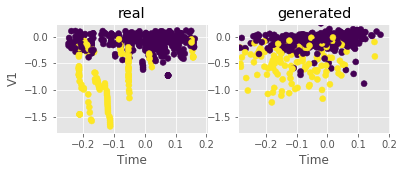

Step: 3400 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0935, -0.0944, -0.0796, 0.8862
D Real - D Gen: 0.0149


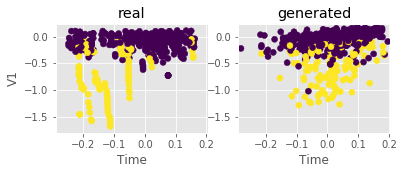

Step: 3500 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0826, -0.0773, -0.0771, 0.8902
D Real - D Gen: 0.0003


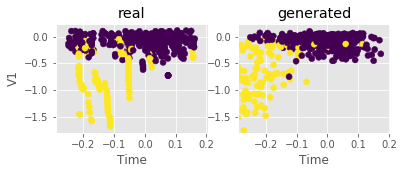

Step: 3600 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.1183, -0.1113, -0.1068, 0.8760
D Real - D Gen: 0.0044


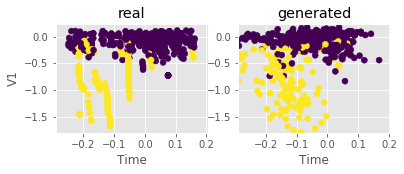

Step: 3700 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0857, -0.0824, -0.0491, 0.8821
D Real - D Gen: 0.0332


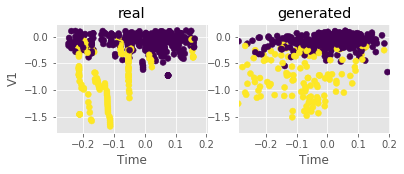

Step: 3800 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0974, -0.1015, -0.0906, 0.8537
D Real - D Gen: 0.0109


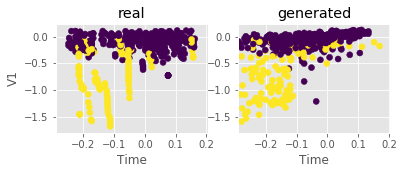

Step: 3900 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0730, -0.0521, -0.0541, 0.8272
D Real - D Gen: -0.0019


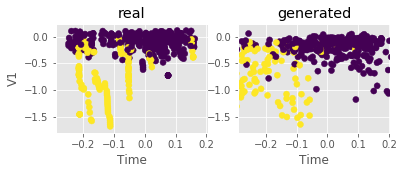

Step: 4000 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0921, -0.0831, -0.0714, 0.8984
D Real - D Gen: 0.0118


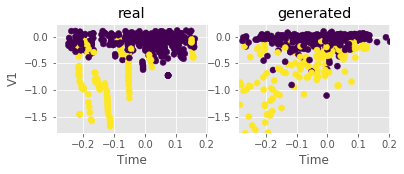

Step: 4100 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0954, -0.0864, -0.0709, 0.8476
D Real - D Gen: 0.0154


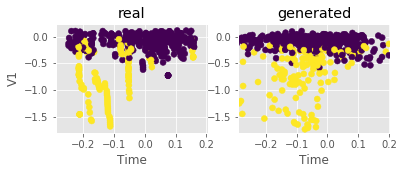

Step: 4200 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0825, -0.0875, -0.0769, 0.8110
D Real - D Gen: 0.0106


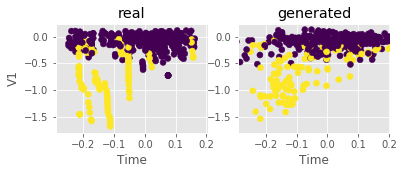

Step: 4300 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0826, -0.0853, -0.0728, 0.8699
D Real - D Gen: 0.0124


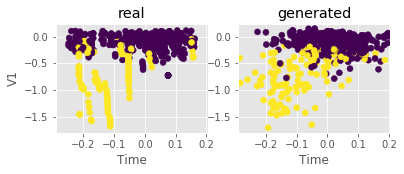

Step: 4400 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0803, -0.0790, -0.0658, 0.8516
D Real - D Gen: 0.0132


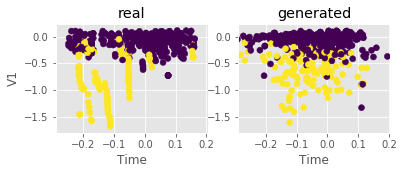

Step: 4500 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0778, -0.0795, -0.0675, 0.8313
D Real - D Gen: 0.0120


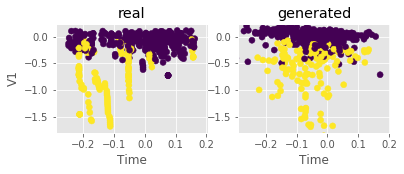

Step: 4600 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.1222, -0.0878, -0.0755, 0.7886
D Real - D Gen: 0.0124


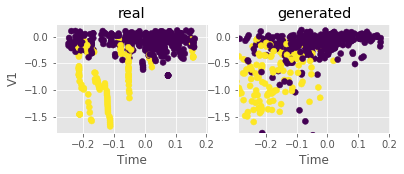

Step: 4700 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0747, -0.0790, -0.0613, 0.8455
D Real - D Gen: 0.0177


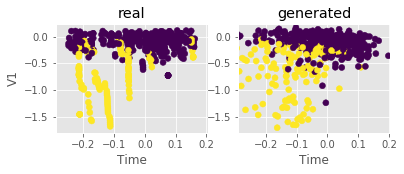

Step: 4800 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0836, -0.0807, -0.0785, 0.8496
D Real - D Gen: 0.0022


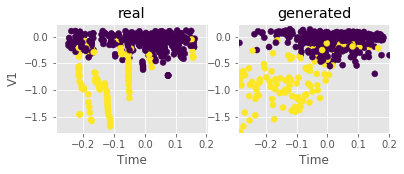

Step: 4900 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0751, -0.0752, -0.0413, 0.8028
D Real - D Gen: 0.0339


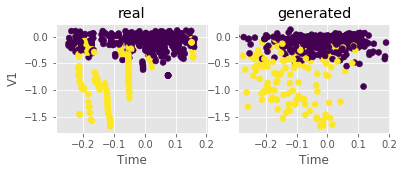

Step: 5000 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0727, -0.0631, -0.0580, 0.8211
D Real - D Gen: 0.0051


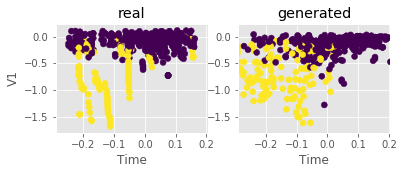

CPU times: user 14min 40s, sys: 1min 4s, total: 15min 44s
Wall time: 4min


In [14]:
%%time
# Training the WGAN and WCGAN architectures
arguments = [rand_dim, nb_steps, batch_size, 
             k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
            data_dir, generator_model_path, discriminator_model_path, loss_pickle_path, show ]

adversarial_training_WGAN(arguments, train_no_label, data_cols=data_cols ) # WGAN
adversarial_training_WGAN(arguments, train, data_cols=data_cols, label_cols=label_cols ) # WCGAN

In [ ]:
# %%time

# # for continued training

# import GAN_1711103
# import importlib
# importlib.reload(GAN_171103) # For reloading after making changes
# from GAN_171103 import *

# last_step = 1000
# prefix = 'WGAN'
# # data_dir = 'cache lr mix base 128 act mix 171026/'
# data_dir = 'cache/'

# # Choose your learning rate
# # learning_rate = 1e-5 # first 10k
# # learning_rate = 1e-5 # 10-15k
# # learning_rate = 1e-6 # 15-20k

# generator_model_path = data_dir + prefix + '_generator_model_weights_step_' + str(last_step) + '.h5'
# discriminator_model_path = data_dir + prefix + '_discriminator_model_weights_step_' + str(last_step) + '.h5'
# loss_pickle_path = data_dir + prefix + '_losses_step_' + str(last_step) + '.pkl'

# nb_steps = 4000

# arguments = [rand_dim, nb_steps, batch_size, 
#              k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
#             data_dir, generator_model_path, discriminator_model_path, loss_pickle_path, show ]

# # Choose your training algorithm
# # adversarial_training_GAN(arguments, train_no_label, data_cols=data_cols, starting_step=last_step+1 ) # GAN
# # adversarial_training_GAN(arguments, train, data_cols=data_cols, label_cols=label_cols, starting_step=last_step+1 ) # CGAN
# # adversarial_training_WGAN(arguments, train_no_label, data_cols=data_cols, starting_step=last_step+1 ) # WGAN
# adversarial_training_WGAN(arguments, train, data_cols=data_cols, label_cols=label_cols, starting_step=last_step+1 ) # WCGAN

In [15]:
# For reloading loss data from pickles
prefix = 'WCGAN'
step = 5000

[combined_loss, disc_loss_generated, disc_loss_real, xgb_losses] = pickle.load(
    open(data_dir+prefix+'_losses_step_'+str(step)+'.pkl','rb'))

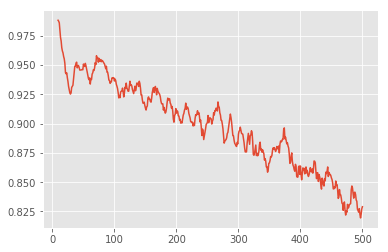

In [16]:
# plt.plot( xgb_losses[:] ) ;
w = 10
plt.plot( pd.DataFrame(xgb_losses[:]).rolling(w).mean() ) ;

In [17]:
# Look for the step with the lowest xgboost accuracy, and the lowest step saved (every 100)
best_step = list(xgb_losses).index( xgb_losses.min() ) * 10
print( best_step, xgb_losses.min() )

xgb100 = [ xgb_losses[i] for i in range(0, len(xgb_losses), 10) ]
best_step = xgb100.index( min(xgb100) ) * log_interval
print( best_step, min(xgb100) )

(4720, 0.7682926829268293)
(4600, 0.7886178861788617)


In [18]:
# Look for the step with the lowest critic loss, and the lowest step saved (every 100)
delta_losses = np.array(disc_loss_real) - np.array(disc_loss_generated)

best_step = list(delta_losses).index( delta_losses.min() )
print( best_step, delta_losses.min() )

delta100 = [ delta_losses[i] for i in range(0, len(delta_losses), 100) ]
best_step = delta100.index( min(delta100) ) * log_interval
print( best_step, min(delta100) )

(1831, -0.06830564)
(3100, -0.0101181865)


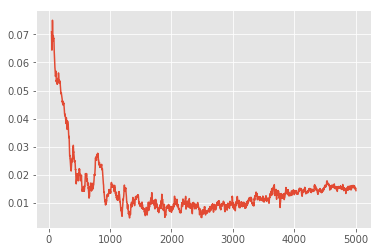

In [19]:
# plt.plot( (np.array(disc_loss_real) - np.array(disc_loss_generated)) )

w = 50
# plt.plot( list(range(0,5001,1)), pd.rolling_mean((np.array(disc_loss_real) - np.array(disc_loss_generated)),w) )
plt.plot( pd.DataFrame(disc_loss_real[:]).rolling(w).mean() - pd.DataFrame(disc_loss_generated[:]).rolling(w).mean() ) ;

# plt.xlim([9000,10000])
# plt.ylim([0.03,0.05])

In [20]:
# Let's look at some of the generated data
# First create the networks locally and load the weights

seed = 17

train = fraud_w_classes.copy().reset_index(drop=True) # fraud only with labels from classification

# train = pd.get_dummies(train, columns=['Class'], prefix='Class', drop_first=True)
label_cols = [ i for i in train.columns if 'Class' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]
train[ data_cols ] = train[ data_cols ] / 10 # scale to random noise size, one less thing to learn
train_no_label = train[ data_cols ]

data_dim = len(data_cols)
label_dim = len(label_cols)
with_class = False
if label_dim > 0: with_class = True
np.random.seed(seed)

# define network models

# generator_model, discriminator_model, combined_model = define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count, type='Wasserstein')
# generator_model.load_weights('cache/WCGAN_generator_model_weights_step_4800.h5')
generator_model, discriminator_model, combined_model = define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count)
generator_model.load_weights('cache/WCGAN_generator_model_weights_step_5000.h5')

# with_class = False
# train = train_no_label
# label_cols = []
# # generator_model, discriminator_model, combined_model = define_models_GAN(rand_dim, data_dim, base_n_count, type='Wasserstein')
# # generator_model.load_weights('cache/WGAN_generator_model_weights_step_4800.h5')

# generator_model, discriminator_model, combined_model = define_models_GAN(rand_dim, data_dim, base_n_count)
# generator_model.load_weights('cache/GAN_generator_model_weights_step_5000.h5')

In [21]:
# Now generate some new data
test_size = 492 # Equal to all of the fraud cases

x = get_data_batch(train, test_size, seed=seed)
z = np.random.normal(size=(test_size, rand_dim))
if with_class:
    labels = x[:,-label_dim:]
    g_z = generator_model.predict([z, labels])
else:
    g_z = generator_model.predict(z)

0.815040650407


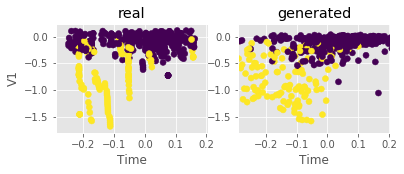

In [22]:
# Check using the same functions used during GAN training

print( CheckAccuracy( x, g_z, data_cols, label_cols, seed=0, with_class=with_class, data_dim=data_dim ) )

PlotData( x, g_z, data_cols, label_cols, seed=0, with_class=with_class, data_dim=data_dim )

In [23]:
# Now we can train and test an xgboost classifier on our generated data

real_samples = pd.DataFrame(x, columns=data_cols+label_cols)
test_samples = pd.DataFrame(g_z, columns=data_cols+label_cols)
real_samples['syn_label'] = 0
test_samples['syn_label'] = 1

training_fraction = 0.5
n_real, n_test = int(len(real_samples)*training_fraction), int(len(test_samples)*training_fraction)
train_df = pd.concat([real_samples[:n_real],test_samples[:n_test]],axis=0)
test_df = pd.concat([real_samples[n_real:],test_samples[n_test:]],axis=0)

# X_col = test_df.columns[:-(label_dim+1)]
X_col = test_df.columns[:-1]
y_col = test_df.columns[-1]
dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
dtest = xgb.DMatrix(test_df[X_col], feature_names=X_col)
y_true = test_df['syn_label']

# dtrain = np.vstack( [ x[:int(len(x)/2)], g_z[:int(len(g_z)/2)] ] )
# dlabels = np.hstack( [ np.zeros(int(len(x)/2)), np.ones(int(len(g_z)/2)) ] )
# dtest = np.vstack( [ x[int(len(x)/2):], g_z[int(len(g_z)/2):] ] )

# dtrain = xgb.DMatrix(dtrain, dlabels, feature_names=data_cols+label_cols)
# dtest = xgb.DMatrix(dtest, feature_names=data_cols+label_cols)
# y_true = dlabels

xgb_params = {
    'max_depth': 4,
    'objective': 'binary:logistic',
    'random_state': 0,
    'eval_metric': 'auc', # allows for balanced or unbalanced classes 
}
xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=10)

y_pred = np.round(xgb_test.predict(dtest))

print( '{:.2f}'.format(SimpleAccuracy(y_pred, y_true)) )

0.82


/Users/khosseini/anaconda3/envs/py27_quipp/lib/python2.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/khosseini/anaconda3/envs/py27_quipp/lib/python2.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


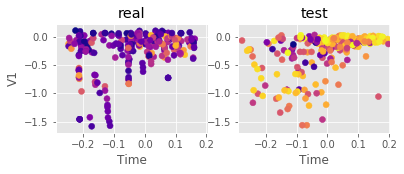

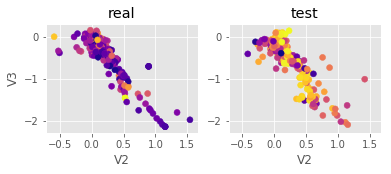

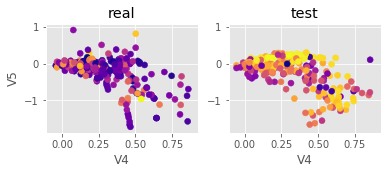

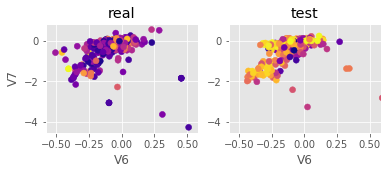

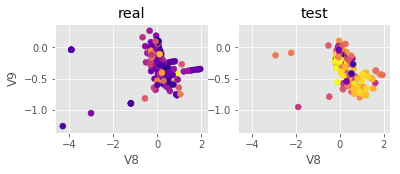

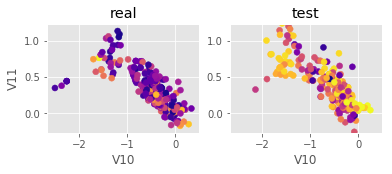

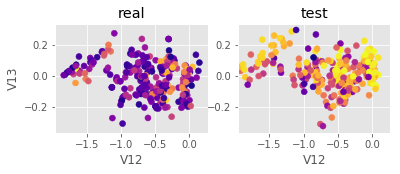

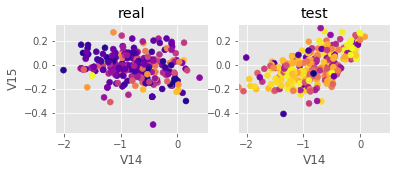

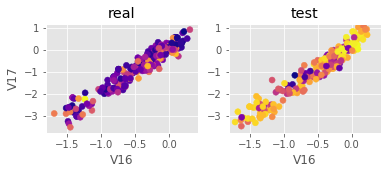

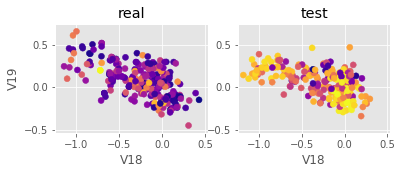

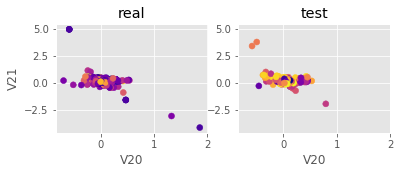

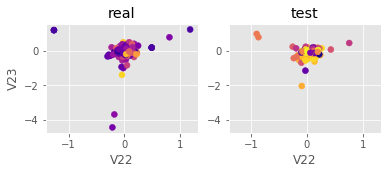

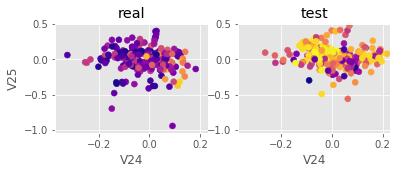

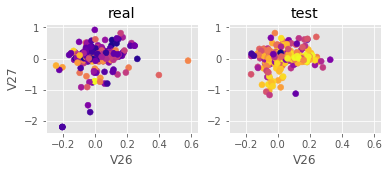

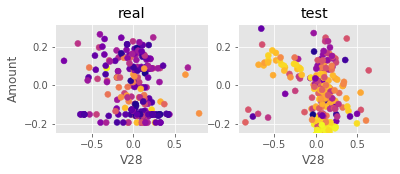

In [24]:
# Let's look at how the discrimnator scored real and generated data, visualized along every feature

y_pred0 = xgb_test.predict(dtest)

for i in range(0,len(X_col)-1, 2):

    f, axarr = plt.subplots(1, 2, figsize=(6,2) )

    axarr[0].scatter( test_df[:n_real][X_col[i]], test_df[:n_real][X_col[i+1]], c=y_pred0[:n_real], cmap='plasma'  )
    axarr[0].set_title('real')
    axarr[0].set_ylabel(X_col[i+1])

    axarr[1].scatter( test_df[n_real:][X_col[i]], test_df[n_real:][X_col[i+1]], c=y_pred0[n_real:], cmap='plasma'  )
    axarr[1].set_title('test')
    axarr[1].set_xlim(axarr[0].get_xlim()), axarr[1].set_ylim(axarr[0].get_ylim())

    for a in axarr:
        a.set_xlabel(X_col[i])

    plt.show()

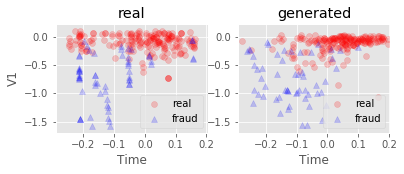

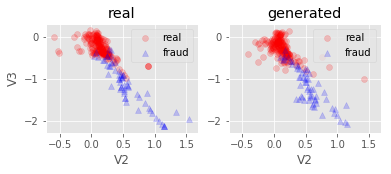

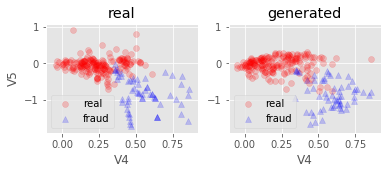

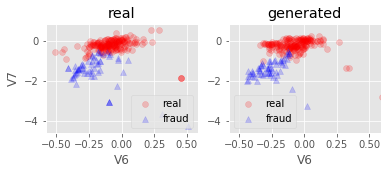

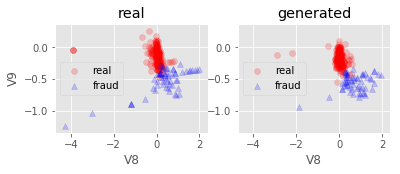

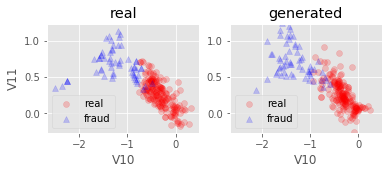

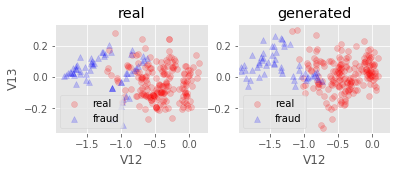

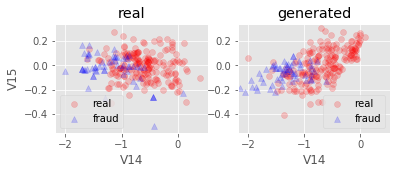

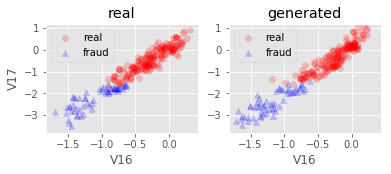

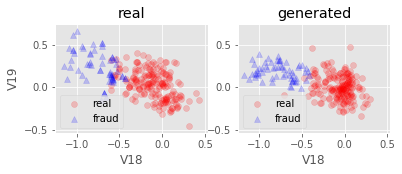

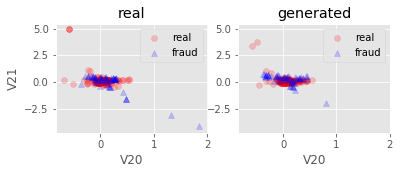

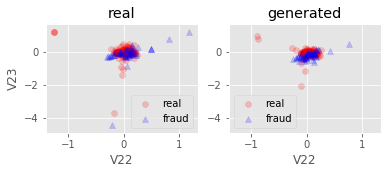

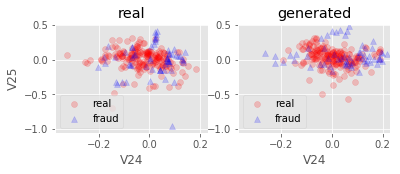

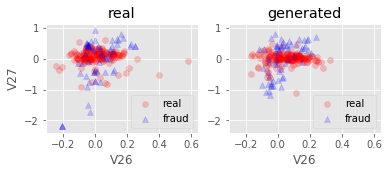

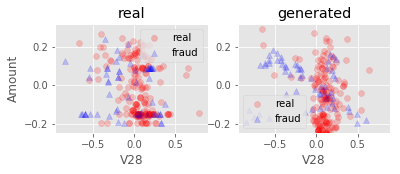

In [25]:
# Now we can compare the real and generated data by class, along every feature

colors = ['red','blue']
markers = ['o','^']
labels = ['real','fraud']

class_label = 'Class'

for i in range(0,len(X_col), 2):
    col1, col2 = i, i+1
    if i+1 >= len(X_col): continue
    
    f, axarr = plt.subplots(1, 2, figsize=(6,2) )
    for group, color, marker, label in zip( test_df[:n_real].groupby(class_label), colors, markers, labels ):
        axarr[0].scatter( group[1][X_col[col1]], group[1][X_col[col2]], label=label, c=color, marker=marker, alpha=0.2) 
    axarr[0].legend()
    axarr[0].set_title('real')
    axarr[0].set_ylabel(X_col[col2])

    for group, color, marker, label in zip( test_df[n_real:].groupby(class_label), colors, markers, labels ):
        axarr[1].scatter( group[1][X_col[col1]], group[1][X_col[col2]], label=label, c=color, marker=marker, alpha=0.2) 
    axarr[1].set_xlim(axarr[0].get_xlim()), axarr[1].set_ylim(axarr[0].get_ylim())
    axarr[1].legend()
    axarr[1].set_title('generated') ;

    for a in axarr:
        a.set_xlabel(X_col[col1])

    plt.show()

In [26]:
# Evaluate performance on validation set

SimpleMetrics(y_pred,y_true)

Confusion Matrix


Pred 0  Pred 1
True 0     206      40
True 1      51     195

Accuracy : 0.815040650407


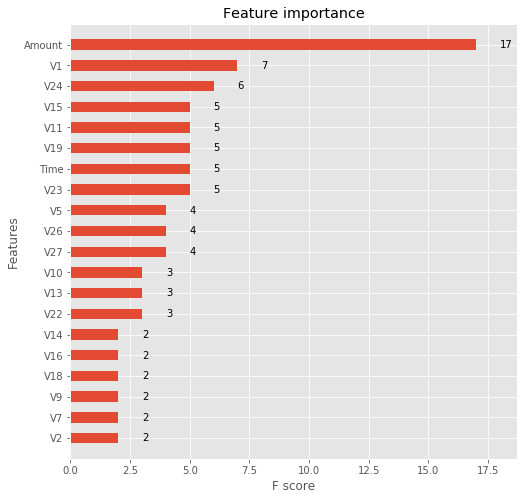

In [27]:
# Plot feature importances used for identifying generated data

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
xgb.plot_importance(xgb_test, max_num_features=20, height=0.5, ax=ax);

## Compare GAN Output

In [28]:
# Set up the training dataset

train = fraud_w_classes.copy().reset_index(drop=True) # fraud only with labels from classification

train = pd.get_dummies(train, columns=['Class'], prefix='Class', drop_first=True)
label_cols = [ i for i in train.columns if 'Class' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]
train[ data_cols ] = train[ data_cols ] / 10 # scale to random noise size, one less thing to learn
train_no_label = train[ data_cols ]

data_dim = len(data_cols)
label_dim = len(label_cols)

In [29]:
# Generate empty models

rand_dim = 32
base_n_count = 128
model_names = ['GAN','CGAN','WGAN','WCGAN']
with_classes = [False, True, False, True]
type0s = [None, None, 'Wasserstein', 'Wasserstein']

models = {}

for model_name, with_class, type0 in zip(model_names, with_classes, type0s ):

    if with_class:
        generator_model, discriminator_model, combined_model = \
            define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count, type=type0)
    else:
         generator_model, discriminator_model, combined_model = \
            define_models_GAN(rand_dim, data_dim, base_n_count, type=type0)   
    
    models[model_name] = [ model_name, with_class, type0, generator_model ]

In [30]:
# Setup parameters

seed = 17
test_size = 492 # number of fraud cases

np.random.seed(seed)
z = np.random.normal(size=(test_size, rand_dim))
x = get_data_batch(train, test_size, seed=seed)
real_samples = pd.DataFrame(x, columns=data_cols+label_cols)
labels = x[:,-label_dim:]

# colors = ['C1','C9']
# colors = ['xkcd:plum', 'xkcd:navy']
colors = ['red','blue']
markers = ['o','^']
class_labels = ['Class 1','Class 2']

col1, col2 = 'V10', 'V17'

base_dir = 'cache/'

0
100
200
500
1000
2000
5000


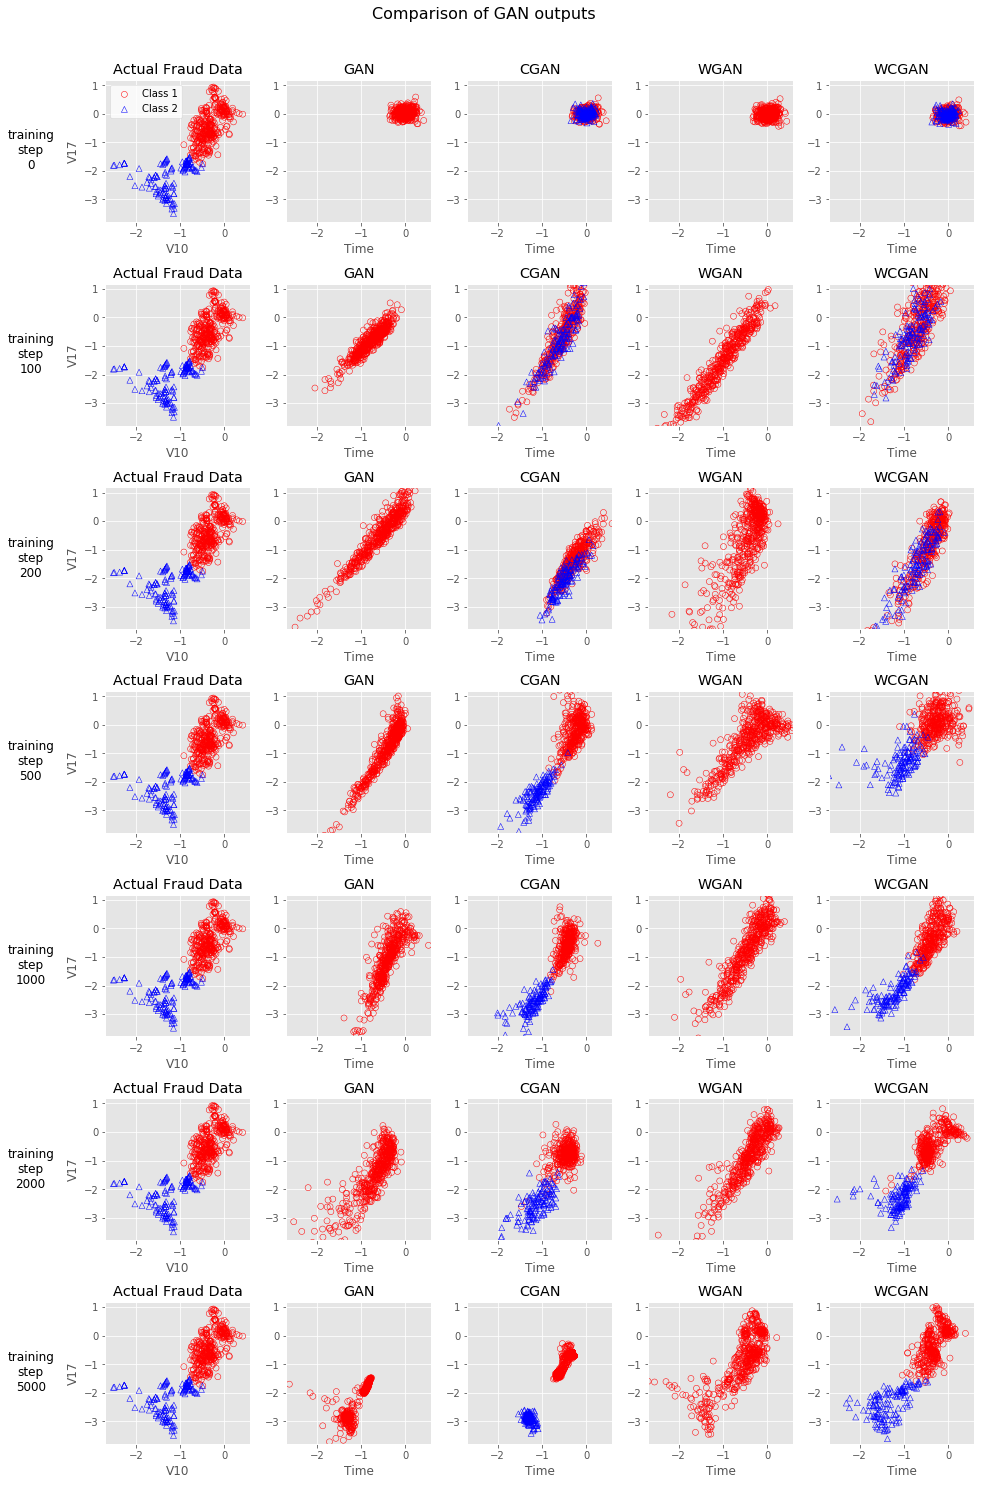

In [32]:
# model_steps = [500, 5000]
# model_steps = [ 0, 100, 200, 500, 1000 ]
model_steps = [ 0, 100, 200, 500, 1000, 2000, 5000]
#model_steps = [ 0, 100, 200, 500]
rows = len(model_steps)
columns = 5

axarr = [[]]*len(model_steps)

fig = plt.figure(figsize=(14,rows*3))

for model_step_ix, model_step in enumerate( model_steps ):
    print(model_step)
        
    axarr[model_step_ix] = plt.subplot(rows, columns, model_step_ix*columns + 1)
    
    for group, color, marker, label in zip( real_samples.groupby('Class_1'), colors, markers, class_labels ):
        plt.scatter( group[1][[col1]], group[1][[col2]], 
                         label=label, marker=marker, edgecolors=color, facecolors='none' )
    
    plt.title('Actual Fraud Data')
    plt.ylabel(col2) # Only add y label to left plot
    plt.xlabel(col1)
    xlims, ylims = axarr[model_step_ix].get_xlim(), axarr[model_step_ix].get_ylim()
        
    if model_step_ix == 0: 
        legend = plt.legend()
        legend.get_frame().set_facecolor('white')
    
    for i, model_name in enumerate( model_names[:] ):
        
        [ model_name, with_class, type0, generator_model ] = models[model_name]
        
        generator_model.load_weights( base_dir + model_name + '_generator_model_weights_step_'+str(model_step)+'.h5')

        ax = plt.subplot(rows, columns, model_step_ix*columns + 1 + (i+1) )
        
        if with_class:
            g_z = generator_model.predict([z, labels])
            gen_samples = pd.DataFrame(g_z, columns=data_cols+label_cols)
            for group, color, marker, label in zip( gen_samples.groupby('Class_1'), colors, markers, class_labels ):
                plt.scatter( group[1][[col1]], group[1][[col2]], 
                                 label=label, marker=marker, edgecolors=color, facecolors='none' )
        else:
            g_z = generator_model.predict(z)
            gen_samples = pd.DataFrame(g_z, columns=data_cols)
            plt.scatter( gen_samples[[col1]], gen_samples[[col2]], 
                             label=class_labels[0], marker=markers[0], edgecolors=colors[0], facecolors='none' )
        plt.title(model_name)   
        plt.xlabel(data_cols[0])
        ax.set_xlim(xlims), ax.set_ylim(ylims)


plt.suptitle('Comparison of GAN outputs', size=16)
plt.tight_layout(rect=[0.075,0,1,0.95])

# Adding text labels for traning steps
vpositions = np.array([ i._position.bounds[1] for i in axarr ])
vpositions += ((vpositions[0] - vpositions[1]) * 0.35 )
for model_step_ix, model_step in enumerate( model_steps ):
    fig.text( 0.05, vpositions[model_step_ix], 'training\nstep\n'+str(model_step), ha='center', va='center', size=12)

# plt.savefig('plots/Comparison_of_GAN_outputs.png')

In [33]:
gen_samples

Time        V1        V2        V3        V4        V5        V6  \
0   -0.112504 -1.249020  0.974588 -1.796876  0.467290 -1.369110 -0.450003   
1   -0.216603 -1.345692  0.963316 -1.852998  0.453203 -1.284109 -0.019194   
2    0.117632 -0.028975  0.150585 -0.190977  0.228864  0.238684 -0.113359   
3   -0.194256 -1.052550  0.451111 -1.430720  0.676470 -1.124926 -0.366117   
4   -0.247041 -0.340431  0.455661 -0.758428  0.642852 -0.588225 -0.218248   
5    0.009350 -0.067491  0.015637  0.054934  0.047281  0.058726  0.002060   
6   -0.010977 -0.077254  0.044669  0.111141  0.099923  0.097436  0.005176   
7    0.119117 -0.031158  0.036346 -0.028708  0.077831  0.030129  0.010136   
8   -0.192977 -0.044164  0.172211 -0.071676  0.324109  0.248276 -0.037154   
9   -0.195450 -0.076602  0.060693 -0.154831  0.174287 -0.034573 -0.065454   
10   0.130782 -0.092586  0.033312  0.092603  0.052714  0.019178  0.055036   
11  -0.111430 -0.828260  0.466722 -1.131617  0.573846 -1.019569 -0.282416   
12   0.182498 -0.138386  0.030867 -0.309652  0.116826 -0.213961 -0.029083   
13   0.012586 -0.131827  0.302920 -0.573792  0.444496 -0.186496 -0.124362   
14   0.039179  0.010694  0.051020  0.009934  0.180521 -0.131611 -0.062301   
15   0.093335 -0.036876  0.138804 -0.363899  0.394887  0.165110 -0.208877   
16   0.081813 -0.053795  0.079999 -0.114588  0.136212 -0.143981 -0.024658   
17  -0.055066 -0.539245  0.294898 -0.710198  0.555312 -0.707963 -0.212902   
18   0.135461 -0.063794 -0.040828 -0.025425  0.004562  0.035983 -0.016304   
19   0.153338 -0.062463  0.096076 -0.480605  0.241447  0.112793 -0.205406   
20   0.108776 -0.142048 -0.018782 -0.330254 -0.066169 -0.237161 -0.075049   
21   0.131994 -0.090491 -0.015487 -0.197524  0.039725  0.041408  0.022695   
22   0.069615 -0.193935  0.097282 -0.045661  0.136994  0.092431  0.192166   
23   0.221568 -0.023813  0.160077 -0.497360  0.346496  0.122859 -0.177084   
24   0.111177 -0.466647 -0.245260 -0.585406  0.265940  0.048931 -0.183236   
25   0.142123 -0.181572 -0.086315 -0.487741  0.099582 -0.459011  0.084291   
26   0.083625 -0.052054  0.100114 -0.244966  0.247330 -0.108253 -0.087746   
27  -0.215602 -0.177446  0.555674 -0.867726  0.599162 -0.121893 -0.220740   
28   0.055004 -0.021640  0.041377 -0.107890  0.124360 -0.058608 -0.096008   
29   0.105548 -0.024160  0.048896 -0.093516  0.114034 -0.146466 -0.052125   
..        ...       ...       ...       ...       ...       ...       ...   
462 -0.146559  0.004328  0.170449 -0.196690  0.235338  0.353995 -0.243447   
463 -0.027912 -0.964873  0.481284 -1.121118  0.590619 -1.092862 -0.291468   
464 -0.030928 -0.224185  0.148371 -0.321210  0.294324 -0.101774 -0.150324   
465 -0.140671 -0.986528  0.487047 -1.329695  0.667797 -1.192787 -0.340382   
466 -0.259617 -0.841271  0.710645 -1.325194  0.716583 -1.121188 -0.216680   
467  0.087772 -0.018843  0.209151 -0.641383  0.441611  0.288001 -0.398284   
468  0.009701 -0.102940  0.084567 -0.300091  0.103172 -0.193510 -0.172614   
469 -0.054043 -0.261965  0.192663 -0.478526  0.497252 -0.400150 -0.174572   
470 -0.232274 -0.317476  0.402628 -0.735476  0.645869 -0.571380 -0.210350   
471  0.091593 -0.171329  0.203575 -0.590348  0.379099 -0.140019 -0.129375   
472  0.072280 -0.249023  0.121985 -0.398831  0.324358 -0.249385 -0.090880   
473  0.089182 -0.005207  0.107525 -0.124755  0.121154  0.154093 -0.084241   
474 -0.120260 -0.028974  0.010968 -0.188553  0.098176  0.095656 -0.194667   
475 -0.028288 -0.109539  0.171216 -0.186169  0.306751  0.029882 -0.161207   
476  0.081944 -1.051771  1.450534 -1.069274  0.312339 -0.734727  0.629151   
477  0.068715 -0.223803  0.072180 -0.241163  0.045333 -0.409292 -0.077725   
478  0.101684 -0.050226  0.068135 -0.050827  0.061256  0.036796 -0.067939   
479  0.178490 -0.036996  0.160630 -0.315449  0.227182 -0.077047 -0.072256   
480 -0.004429 -0.406014  0.150867 -0.548040  0.252638 -0.300170 -0.043607   
481 -0.247947 -0.814576  0.668009 -1.273454  0.561378 -0.887784 -0.175153   
482  

## Generated Data Testing

In [36]:
# Setup xgboost parameters

xgb_params = {
#     'max_depth': 4,
    'objective': 'binary:logistic',
    'random_state': 0,
    'eval_metric': 'auc', # auc, error
#     'tree_method': 'hist'
#     'grow_policy': 'lossguide' # depthwise, lossguide
}

# https://github.com/dmlc/xgboost/blob/master/demo/guide-python/custom_objective.py

from sklearn.metrics import recall_score, precision_score, roc_auc_score

def recall(preds, dtrain):
    labels = dtrain.get_label()
    return 'recall',  recall_score(labels, np.round(preds))

def precision(preds, dtrain):
    labels = dtrain.get_label()
    return 'precision',  precision_score(labels, np.round(preds))

def roc_auc(preds, dtrain):
    labels = dtrain.get_label()
    return 'roc_auc',  roc_auc_score(labels, preds)

In [37]:
# Define model parameters

seed = 17
np.random.seed(seed)

data_dim = len(data_cols)
label_dim = len(label_cols)

base_dir = 'cache/'
rand_dim = 32
base_n_count = 128

In [38]:
# defined training set parameters

train_fraction = 0.7
X_col = data.columns[:-1]
y_col = data.columns[-1]

folds = 5

In [39]:
# Function to make cross folds with different amounts of an additional dataset added

def MakeCrossFolds( g_z_df=[] ):

    np.random.seed(0)

    train_real_set, test_real_set = [], []
    train_fraud_set, test_fraud_set = [], []

    real_samples = data.loc[ data.Class==0 ].copy()
    fraud_samples = data.loc[ data.Class==1 ].copy()

#     n_temp_real = 10000 
    n_temp_real = len(real_samples)

    for seed in range(folds):
        np.random.seed(seed)

        fraud_samples = fraud_samples.sample(len(fraud_samples), replace=False).reset_index(drop=True) # shuffle

    #     n_train_fraud = int(len(fraud_samples) * train_fraction)
        n_train_fraud = 100
        train_fraud_samples = fraud_samples[:n_train_fraud].reset_index(drop=True)

    #     test_fraud_samples = fraud_samples[n_train_fraud:].reset_index(drop=True)
        n_test_fraud = 148 # 30% left out
        test_fraud_samples = fraud_samples[-n_test_fraud:].reset_index(drop=True)

        if len(g_z_df)==0: g_z_df = fraud_samples[n_train_fraud:-n_test_fraud] # for adding real data, if no generated
        n_g_z = len(g_z_df)
        train_fraud_samples = train_fraud_samples.append(g_z_df).reset_index(drop=True)

        real_samples = real_samples.sample(len(real_samples), replace=False).reset_index(drop=True) # shuffle
        temp_real_samples = real_samples[:n_temp_real]
        n_train_real = int(len(temp_real_samples) * train_fraction)

        train_real_samples = temp_real_samples[:n_train_real].reset_index(drop=True) # with margin
        test_real_samples = temp_real_samples[n_train_real:].reset_index(drop=True) # with margin

        train_real_set.append( train_real_samples )
        test_real_set.append( test_real_samples )
        train_fraud_set.append( train_fraud_samples )
        test_fraud_set.append( test_fraud_samples )

    print( n_train_fraud )
    for i in [ fraud_samples, g_z_df, train_fraud_samples, test_fraud_samples ]: print( len(i) )
    for i in [ real_samples, train_real_samples, test_real_samples ]: print( len(i) )
    # [ [ len(i) for i in j ] for j in [train_real_set, test_real_set, train_fraud_set, test_fraud_set] ]
    
    return n_train_fraud, train_real_set, test_real_set, train_fraud_set, test_fraud_set

In [40]:
# function to run an xgboost classifier on different cross-folds with different amounts of data added

def Run_CV_Xgb(n_train_fraud, train_real_set, test_real_set, train_fraud_set, test_fraud_set):

    test_data=[]

    # for i in [1]:
    # for i in [1,2,5,10,20]:
    # for i in np.logspace(0,np.log10(11),num=5):
    # for i in np.logspace(0,np.log10(11),num=3):
    for i in np.logspace(0,np.log10((492-148)/100),num=5):

        print('# additional generated data tested: {}'.format (int(n_train_fraud*(i-1)) ) )
        for k in range(folds):

            train_df = pd.concat( 
                [ train_real_set[k], train_fraud_set[k][:int(n_train_fraud*i)] ],
                 axis=0,ignore_index=True).reset_index(drop=True)

            test_df = pd.concat( 
                [ test_real_set[k], test_fraud_set[k] ],
                axis=0,ignore_index=True).reset_index(drop=True)

            dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
            dtest = xgb.DMatrix(test_df[X_col], test_df[y_col], feature_names=X_col)

            results_dict = {}
            xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=100, 
                                 verbose_eval=False, early_stopping_rounds=10, 
                                 evals=[(dtrain,'train'),(dtest,'test')],
                                 evals_result = results_dict )

            y_pred = xgb_test.predict(dtest, ntree_limit=xgb_test.best_iteration+1)
            y_true = test_df['Class'].values
            results = [k, i, xgb_test.best_iteration, recall( y_pred, dtest )[1], precision( y_pred, dtest )[1], roc_auc( y_pred, dtest )[1] ]
    #         print(results)

            test_data.append(results)
    test_data = pd.DataFrame(test_data, columns=['k', 'ratio','best','recall','precision','auc'])
    return test_data

In [41]:
%%time

# Generate and test data with untrained model

generator_model, discriminator_model, combined_model = define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count, type='Wasserstein')
generator_model.load_weights( base_dir + 'WCGAN_generator_model_weights_step_0.h5')

test_size = 492
x = get_data_batch(fraud_w_classes, test_size, seed=0)
z = np.random.normal(size=(test_size, rand_dim))
labels = x[:,-label_dim:]
g_z = generator_model.predict([z, labels])


# The labels for the generate data will all be 1, as they are supposed to be fraud data
g_z_df = pd.DataFrame( np.hstack( [g_z[:,:len(data_cols)], np.ones((len(g_z),1))] ), columns=data.columns )

n_train_fraud, train_real_set, test_real_set, train_fraud_set, test_fraud_set = MakeCrossFolds(g_z_df)
    
t_0 = Run_CV_Xgb(n_train_fraud, train_real_set, test_real_set, train_fraud_set, test_fraud_set)

100
492
492
592
148
284315
199020
85295
# additional generated data tested: 0
# additional generated data tested: 31
# additional generated data tested: 73
# additional generated data tested: 127
# additional generated data tested: 200
CPU times: user 12min 24s, sys: 3.79 s, total: 12min 28s
Wall time: 12min 30s


In [42]:
%%time

# Generate and test data with trained model

generator_model, discriminator_model, combined_model = define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count, type='Wasserstein')
generator_model.load_weights( base_dir + 'WCGAN_generator_model_weights_step_4800.h5')

test_size = 492
x = get_data_batch(fraud_w_classes, test_size, seed=0)
z = np.random.normal(size=(test_size, rand_dim))
labels = x[:,-label_dim:]
g_z = generator_model.predict([z, labels])



# The labels for the generate data will all be 1, as they are supposed to be fraud data
g_z_df = pd.DataFrame( np.hstack( [g_z[:,:len(data_cols)], np.ones((len(g_z),1))] ), columns=data.columns )

n_train_fraud, train_real_set, test_real_set, train_fraud_set, test_fraud_set = MakeCrossFolds(g_z_df)
    
t_4800 = Run_CV_Xgb(n_train_fraud, train_real_set, test_real_set, train_fraud_set, test_fraud_set)

100
492
492
592
148
284315
199020
85295
# additional generated data tested: 0
# additional generated data tested: 31
# additional generated data tested: 73
# additional generated data tested: 127
# additional generated data tested: 200
CPU times: user 9min 28s, sys: 3.02 s, total: 9min 31s
Wall time: 9min 31s


In [43]:
%%time

# Generate and test data with additional real data

n_train_fraud, train_real_set, test_real_set, train_fraud_set, test_fraud_set = MakeCrossFolds()
    
t_real = Run_CV_Xgb(n_train_fraud, train_real_set, test_real_set, train_fraud_set, test_fraud_set)

100
492
244
344
148
284315
199020
85295
# additional generated data tested: 0
# additional generated data tested: 31
# additional generated data tested: 73
# additional generated data tested: 127
# additional generated data tested: 200
CPU times: user 12min 32s, sys: 2.84 s, total: 12min 35s
Wall time: 12min 36s


In [44]:
# Save the testing data

# Run using the WCGAN trained after 0 steps
pickle.dump( t_0, open('cache/additional untrained generated fraud data test.pkl','wb'))

# Run using the WCGAN trained after 4800 steps
pickle.dump( t_4800, open('cache/additional generated fraud data test.pkl','wb'))

# Run using the real data
pickle.dump( t_real, open('cache/additional real fraud data test.pkl','wb'))

In [45]:
# Reload the testing data

t_0 = pickle.load(open('cache/additional untrained generated fraud data test.pkl','rb'))
t_4800 = pickle.load(open('cache/additional generated fraud data test.pkl','rb'))
t_real = pickle.load(open('cache/additional real fraud data test.pkl','rb'))

## Effects of Additional Data on Fraud Detection¶

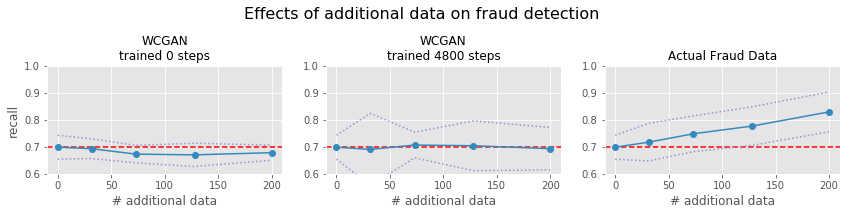

In [46]:

# Plot the testing data

labels = ['WCGAN\ntrained 0 steps','WCGAN\ntrained 4800 steps','Actual Fraud Data']

metric = 'recall'

plt.figure(figsize=(12,3))
for i, [label, test_data] in enumerate(zip(labels, [t_0, t_4800, t_real])):

    xs = [ n_train_fraud * (j[0]-1) for j in test_data.groupby('ratio') ]
    ys = test_data.groupby('ratio')[metric].mean().values
    stds = 2 * test_data.groupby('ratio')[metric].std().values

    plt.subplot(1,3,i+1)
    plt.axhline(ys[0],linestyle='--',color='red')
    plt.plot(xs,ys,c='C1',marker='o')
    plt.plot(xs,ys+stds,linestyle=':',c='C2')
    plt.plot(xs,ys-stds,linestyle=':',c='C2')
    if i==0: plt.ylabel(metric)
    plt.xlabel('# additional data')
    plt.title(label,size=12)
#     plt.xlim([0,11])
#     plt.ylim([0.55,.85])
    plt.ylim([0.6,1.0])

plt.tight_layout(rect=[0,0,1,0.9])
plt.suptitle('Effects of additional data on fraud detection', size=16)
# plt.savefig('plots/Effects of addtional data on fraud detection.png')
plt.show()

## Summary of Training Data

In [47]:
# Load the saved loss data from each model

# base_dir = 'cache/'
base_dir = 'cache/'

suffix = '_step_5000'

GAN_losses = pickle.load(open(base_dir + 'GAN_losses'+suffix+'.pkl','rb'))
# GAN_losses = [combined_loss, disc_loss_real, disc_loss_generated, xgb_losses]

CGAN_losses = pickle.load(open(base_dir + 'CGAN_losses'+suffix+'.pkl','rb'))
WGAN_losses = pickle.load(open(base_dir + 'WGAN_losses'+suffix+'.pkl','rb'))
WCGAN_losses = pickle.load(open(base_dir + 'WCGAN_losses'+suffix+'.pkl','rb'))

In [48]:
# Find best xgb scores overall and saved (every 100 steps)

data_ix = 3
data_sets = [ GAN_losses[data_ix], CGAN_losses[data_ix], WGAN_losses[data_ix], WCGAN_losses[data_ix]]
labels = [ 'GAN','CGAN','WGAN','WCGAN' ]

for label, data_set in zip( labels, data_sets ):
    best_step = list(data_set).index( np.array(data_set).min() ) * 10
    print( '{: <5} step {: <4}: {:.4f}'.format( label, best_step, np.array(data_set).min() ) )

    xgb100 = [ data_set[i] for i in range(0, len(data_set), 10) ]
    best_step = xgb100.index( min(xgb100) ) * 100
    print( '{: <5} step {: <4}: {:.4f}\n'.format( label, best_step, np.array(xgb100).min() ) )
#     print( best_step, min(xgb100) )

GAN   step 2160: 0.7785
GAN   step 2300: 0.8049

CGAN  step 2050: 0.7744
CGAN  step 1700: 0.7927

WGAN  step 4750: 0.7927
WGAN  step 4200: 0.8333

WCGAN step 4720: 0.7683
WCGAN step 4600: 0.7886



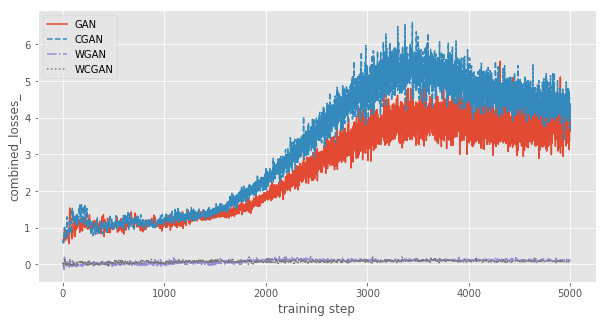

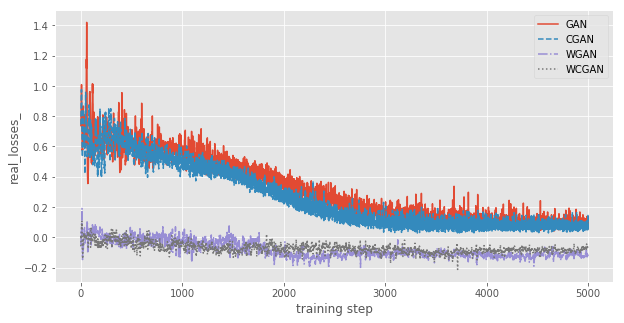

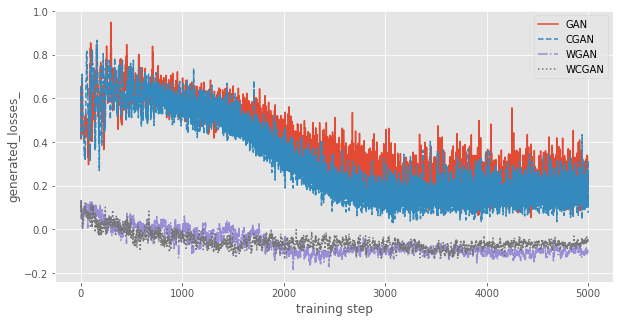

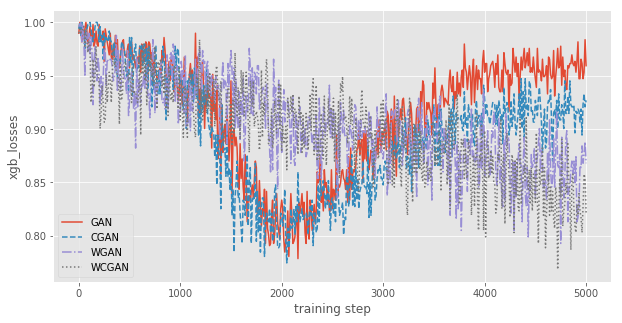

In [49]:
# Look at the unsmoothed losses

data_fields = ['combined_losses_', 'real_losses_', 'generated_losses_', 'xgb_losses']
sampling_intervals = [ 1, 1, 1, 10 ]
labels = [ 'GAN','CGAN','WGAN','WCGAN' ]
linestyles = ['-', '--', '-.', ':']

for data_ix in range(len(data_fields)):
    data_sets = [ GAN_losses[data_ix], CGAN_losses[data_ix], WGAN_losses[data_ix], WCGAN_losses[data_ix]]

    plt.figure(figsize=(10,5))
    for data, label, linestyle in zip(data_sets, labels, linestyles):
        plt.plot( np.array(range(0,len(data)))*sampling_intervals[data_ix],
                 data,
                 label=label, linestyle=linestyle )

    plt.ylabel(data_fields[data_ix])
    plt.xlabel('training step')
    plt.legend()
    plt.show()

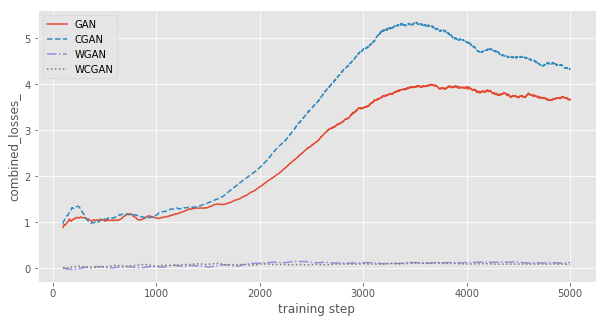

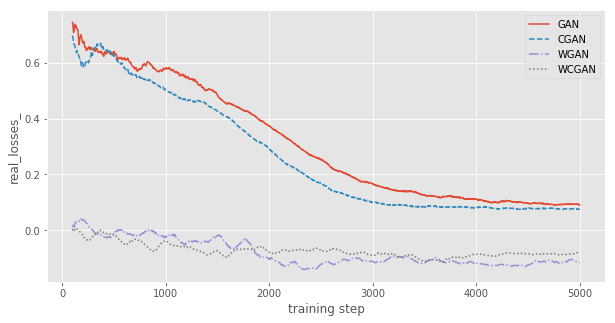

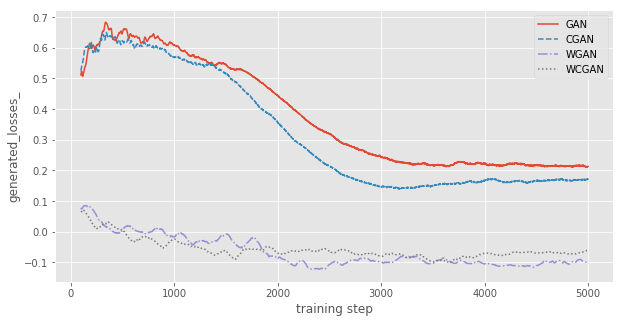

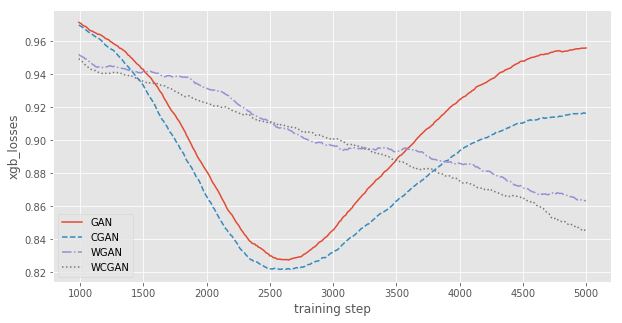

In [50]:
# Look at the smoothed losses

data_fields = ['combined_losses_', 'real_losses_', 'generated_losses_', 'xgb_losses']
sampling_intervals = [ 1, 1, 1, 10 ]
labels = [ 'GAN','CGAN','WGAN','WCGAN' ]
linestyles = ['-', '--', '-.', ':']

w = 100
for data_ix in range(len(data_fields)):
    data_sets = [ GAN_losses[data_ix], CGAN_losses[data_ix], WGAN_losses[data_ix], WCGAN_losses[data_ix]]

    plt.figure(figsize=(10,5))
    for data, label, linestyle in zip(data_sets, labels, linestyles):
        plt.plot( np.array(range(0,len(data)))*sampling_intervals[data_ix],
                 pd.DataFrame(data).rolling(w).mean(),
                 label=label, linestyle=linestyle )

    plt.ylabel(data_fields[data_ix])
    plt.xlabel('training step')
    plt.legend()
    plt.show()

## Accuracy of Generated Data Detection

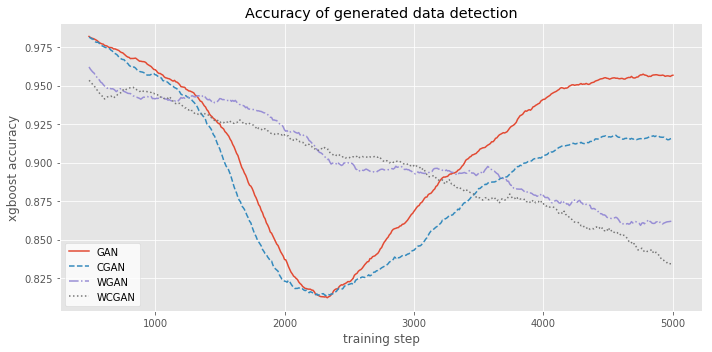

In [51]:
# Create a figure for the smoothed xgboost losses

data_fields = ['combined_losses_', 'real_losses_', 'generated_losses_', 'xgb_losses']
sampling_intervals = [ 1, 1, 1, 10 ]
labels = [ 'GAN','CGAN','WGAN','WCGAN' ]
linestyles = ['-', '--', '-.', ':']

w = 50
data_ix = 3

data_sets = [ GAN_losses[data_ix], CGAN_losses[data_ix], WGAN_losses[data_ix], WCGAN_losses[data_ix]]

plt.figure(figsize=(10,5))
for data, label, linestyle in zip(data_sets, labels, linestyles):
    plt.plot( np.array(range(0,len(data)))*sampling_intervals[data_ix],
             pd.DataFrame(data).rolling(w).mean(),
             label=label, linestyle=linestyle )

plt.ylabel(data_fields[data_ix])
plt.xlabel('training step')
legend = plt.legend() 
legend.get_frame().set_facecolor('white')

plt.title('Accuracy of generated data detection')
plt.ylabel('xgboost accuracy')
plt.tight_layout() ;
# plt.savefig('plots/GAN_accuracy.png')

##  Differences in Critic Loss

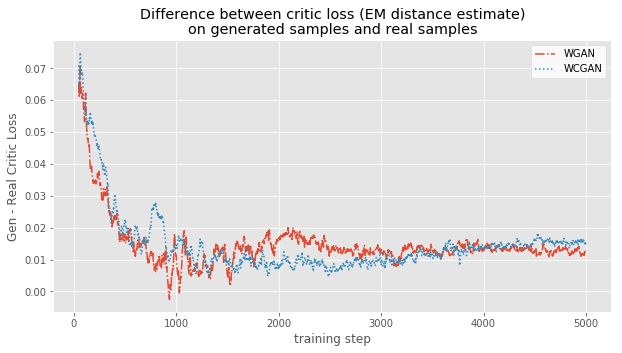

In [52]:
# Create a figure for the critic losses for the WGAN and WCGAN

w = 50

data_ix0 = 2
data_ix1 = 1
data_fields = ['combined_losses_', 'real_losses_', 'generated_losses_', 'xgb_losses']

i1, i2 = 2, 3
i2 += 1

labels = [ 'GAN','CGAN','WGAN','WCGAN' ][i1:i2]
data_sets0 = [ GAN_losses[data_ix0], CGAN_losses[data_ix0], WGAN_losses[data_ix0], WCGAN_losses[data_ix0]][i1:i2]
data_sets1 = [ GAN_losses[data_ix1], CGAN_losses[data_ix1], WGAN_losses[data_ix1], WCGAN_losses[data_ix1]][i1:i2]
linestyles = ['-', '--', '-.', ':'][i1:i2]

plt.figure(figsize=(10,5))
for data0, data1, label, linestyle in zip(data_sets0, data_sets1, labels, linestyles):
    plt.plot( range(0,len(data0)), 
             pd.DataFrame( np.array(data0)-np.array(data1) ).rolling(w).mean(),  
             label=label, linestyle=linestyle )
plt.title('Difference between critic loss (EM distance estimate)\non generated samples and real samples')
plt.xlabel('training step')
plt.ylabel('Gen - Real Critic Loss')
legend = plt.legend() 
legend.get_frame().set_facecolor('white')
# plt.savefig('plots/Delta_critic_loss_plot.png')